# LEOHS (Landsat ETM+ OLI Harmonization Script)
Coded by Galen Richardson. https://scholar.google.ca/citations?user=7of4NM0AAAAJ&hl=en&oi=ao

In [1]:
import geopandas as gpd #geospatial libraries
from shapely.geometry import Point, box
import rasterio,ee,geemap
from rasterio.features import geometry_mask
from geopy.distance import distance
import pandas as pd #basics
import numpy as np
import warnings,joblib,time,random,re,os,shutil
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt #plotting
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime
from joblib import Parallel, delayed #parallel processing
from scipy.stats import gaussian_kde #regression
from scipy.odr import ODR, Model, RealData
from sklearn.linear_model import LinearRegression,TheilSenRegressor
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AUJR-x6RQm0lOaJjH42upmYo_rWvsTVafqRrbtxtnOkRqFafE567aR7UoMI

Successfully saved authorization token.


## Variables
These Variables are user defined and can be used to customize the output of the tool

In [26]:
###Define Image collections###
LS8 = "LANDSAT/LC08/C02/T1_L2"
LS7 = "LANDSAT/LE07/C02/T1_L2"

#LS8 = "LANDSAT/LC08/C02/T1_TOA"
#LS7 = "LANDSAT/LE07/C02/T1_TOA"

harmonization_order=[LS7,LS8]
#an order of [LS7,LS8] means you will get an equation for making LS7 look like LS8

Aoi_shp_path= r'E:\GIS\Landsat Normalization\Test_AOIS\Austria.shp'
#AOI shapefile for the region you want to create normalization coeficients for
#Perfomance might be lower on AOI's that cover less than 10 WRS tiles

wrs_shp_path=r'E:\GIS\Landsat Normalization\Landsat_WRS_index\WRS_overlaps.shp'
#This is the link to WRS_overlaps.shp. It is necessary for finding overlaps

Save_data=True
Save_folder_path=r'E:\GIS\Landsat Normalization\Austria'

months=[7,8]#needs to be a list of months
#[1,2,3,4,5,6,7,8,9,10,11,12] is full range of months
years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]#needs to be a list of years
#[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022] is full range of years

maxCloudCover=50 #maximum cloud coverage per Landsat image

CFMask_filtering=True #used to enable CFMask filtering
Water= True #if you want to include Water Pixels (CFMask), Set to True (yes) or False (no)
Snow= False #if you want to include Snow pixels (CFMask), Set to True (yes) or False (no)

Max_img_samples=10 #max number of images sampled between LS7 and LS8 overlap

Pixel_difference=1 #discarding pixels that are 100% different (same EQ as Roy et al)
#this is the maximum difference between LS7 and LS8 pixels allowed
#if the scatterplots look weird, or there is smoke in imagery, set to a lower value like .5 for 50% different

sample_points_n=1000000 #max is 1,000,000 points
#number of random sample points to generate

Regression_types=["OLS","TheilSen"]
#["OLS","TheilSen"]

These functions are necessary for the script to work

In [27]:
num_cores=min(joblib.cpu_count(), 16)-2
def time_tracker(start_time):
    return "{}sec".format(round((datetime.now() - start_time).total_seconds(), 2))
def get_var_names_from_list(in_list):
    # Create a mapping from values to variable names
    value_to_name = {value: name for name, value in globals().items() if isinstance(value, str)}
    # Use this mapping to retrieve the variable names in the order of in_list
    return [value_to_name[value] for value in in_list if value in value_to_name]
def apply_correction_factors (LS8,LS7,gdf):
    if "TOA" in LS8 and "TOA" in LS7:
        return gdf
    elif "TOA" not in LS8 and "TOA" not in LS7:
        columns_to_transform=[col for col in gdf.columns if col not in ['L1_image_id','L2_image_id','geometry']]
        gdf[columns_to_transform]=gdf[columns_to_transform]*0.0000275 - 0.2
        return gdf
    else:
        print('ERROR!!! TOA and SR datasets selected')
def toa_or_sr (LS8,LS7):
    if "toa" in LS8.lower() and "toa" in LS7.lower():
        return "TOA"
    if "toa" in LS8.lower() or "toa" in LS7.lower():
        return "Non-Matching"
    else:
        return "SR"
def create_save_path():
    if Save_data==True: #remakes Save_folder_path
        if os.path.exists(Save_folder_path):
            shutil.rmtree(Save_folder_path)
        os.makedirs(Save_folder_path)

## Step 1. Create Overlap DF and Frequency Map
This step determines if the area of interest is too large to process as a whole in GEE, where if True it would be broken up into strips.Then, the AOI or strips of AOI are passed into GEE, and all the LS7 and LS8 image names that intersect and are within the time and cloud coverage queries are selected. String manipulation is used to get the path/row and date of each image. overlap_df is created by finding overlapes between LS7 and LS8 which are +/- 1 day and +/- 1 path. This is then grouped and counted to create frequency_gdf which shows the number of overlapping LS7 nand LS8 images.

In [28]:
def create_WRS_gdf(input_shp, WRS_shapefile):
    create_save_path()
    #this creates a gdf of only WRS tiles found in the shapefile
    full_AOI=gpd.read_file(input_shp)
    full_AOI=full_AOI.to_crs('EPSG:4326')  # Ensure CRS is set to EPSG:4326
    full_AOI['geometry']=full_AOI.geometry.buffer(0)
    wrsgdf=gpd.read_file(WRS_shapefile)
    wrsgdf=wrsgdf.to_crs('EPSG:4326')
    wrsgdf['geometry']=wrsgdf.geometry.buffer(0)
    overlap_wrs=gpd.sjoin(wrsgdf,full_AOI,how="inner",predicate='intersects')
    df_subset=overlap_wrs[['row1','path1','path2','geometry']].reset_index(drop=True)
    return df_subset,full_AOI
def split_aoi_into_strips(gdf, max_area=1e13):
    projected_gdf=gdf.to_crs('EPSG:8857')  # Project to equal area for calculation
    total_area=projected_gdf.geometry.area.sum()  # Calculate area
    if total_area<max_area:
        print('No need for splitting. Starting timer and proceeding.')
        return gdf, None
    minx,miny,maxx,maxy=gdf.total_bounds
    midy=(miny+maxy)/2  # Calculate the midpoint y-coordinate, make upper and lower strips
    upper_strip,lower_strip=box(minx,midy,maxx,maxy),box(minx,miny,maxx,midy)
    upper_gdf=gpd.overlay(gdf,gpd.GeoDataFrame(geometry=[upper_strip],crs='EPSG:4326'),how='intersection')
    lower_gdf=gpd.overlay(gdf,gpd.GeoDataFrame(geometry=[lower_strip],crs='EPSG:4326'),how='intersection')
    num_strips=int(np.ceil(total_area/max_area))# Determine the number of strips needed based on the area
    strips=[]
    strip_width=(maxx-minx)/num_strips 
    for i in range(num_strips):
        strip_minx=minx+i*strip_width
        strip_maxx=minx+(i+ 1)*strip_width
        upper_vertical_strip=box(strip_minx, midy, strip_maxx, maxy)# Process upper strip
        upper_strip_gdf=gpd.overlay(upper_gdf, gpd.GeoDataFrame(geometry=[upper_vertical_strip], crs='EPSG:4326'), how='intersection')
        strips.append(upper_strip_gdf)
        lower_vertical_strip=box(strip_minx, miny, strip_maxx, midy)# Process lower strip
        lower_strip_gdf=gpd.overlay(lower_gdf, gpd.GeoDataFrame(geometry=[lower_vertical_strip], crs='EPSG:4326'), how='intersection')
        strips.append(lower_strip_gdf)
    strips=[df for df in strips if not df.empty]
    print(f'{len(strips)} Strips created due to input AOI size. Starting timer and Proceeding.')
    return gdf, strips
def date_cloud_aoi_filter(Landsatcollection,month,year,aoi):
    #basic filters based on month, year, cloud coverage, and AOI
    return Landsatcollection\
    .filter(ee.Filter.calendarRange(month, month, 'month')).filter(ee.Filter.calendarRange(year, year, 'year')) \
    .filter(ee.Filter.lte('CLOUD_COVER',maxCloudCover))\
    .filterBounds(aoi)
def get_image_names(image_collection):
    image_ids=image_collection.aggregate_array('system:id').getInfo()
    return image_ids
def extract_date_path_row(image_id):
    #used to extract date,path,row from landsat image name
    date_str=image_id.split('_')[-1]
    row,path=int(image_id.split('_')[-2][3:6]),int(image_id.split('_')[-2][:3])
    return datetime.strptime(date_str,'%Y%m%d'),row,path
def process_names(image_names):
    name_list=[]
    df=None #process the names and make a df from list of image names
    for name in image_names:
        date, row, path=extract_date_path_row(name)
        detailed_name=[name,date, row, path]
        name_list.append(detailed_name)
        df=pd.DataFrame(name_list)
        df.columns=['id', 'date', 'row','path']
        df[['row', 'path']]=df[['row', 'path']].astype(int)
    if df is not None:
        return df
def cycle_through_image_names(LS1, LS2, aoi):
    aoi=geemap.geopandas_to_ee(aoi)
    matching_pairs=[]
    L1_df,L2_df=None, None
    for year in years:
        for month in months:
            L1_SR=date_cloud_aoi_filter(ee.ImageCollection(LS1),month,year,aoi)  # filter date, cloud, aoi
            L2_SR=date_cloud_aoi_filter(ee.ImageCollection(LS2),month,year,aoi)
            L1_names,L2_names=get_image_names(L1_SR),get_image_names(L2_SR)  # get names of all the images that are within the filter
            L1_df,L2_df=process_names(L1_names), process_names(L2_names)  # process the names using string manipulation and make into a df
            if L1_df is not None and not L1_df.empty and L2_df is not None and not L2_df.empty:  # not empty dfs or ones that do not exist
                for index_L1,row_L1 in L1_df.iterrows():
                    # Find rows in L2_df with the same 'row' and 'path' within +1 or -1, and date within 1 day
                    possible_1row_matches=L2_df[(L2_df['row']==row_L1['row']) &
                        ((L2_df['path']==row_L1['path'] + 1) | (L2_df['path']==row_L1['path'] - 1)) &
                        (abs(L2_df['date']-row_L1['date']).dt.days<= 1)]  # this is the formula for finding matches
                    for index_L2, row_L2 in possible_1row_matches.iterrows():
                        matching_pairs.append({'L1_id': row_L1['id'], 'L1_date': row_L1['date'], 'L1_row': row_L1['row'], 'L1_path': row_L1['path'],'L2_id': row_L2['id'], 'L2_date': row_L2['date'], 'L2_row': row_L2['row'], 'L2_path': row_L2['path']})
                    # Find rows in L2_df with same 'row' and edge paths within +1 or -1 date
                    possible_edge_matches=L2_df[(L2_df['row']==row_L1['row']) &
                        ((L2_df['path']==row_L1['path'] + 232) | (L2_df['path']==row_L1['path'] - 232)) &
                        (abs(L2_df['date']-row_L1['date']).dt.days<= 1)]  # this is the formula for finding matches
                    for index_L2, row_L2 in possible_edge_matches.iterrows():
                        matching_pairs.append({'L1_id': row_L1['id'], 'L1_date': row_L1['date'], 'L1_row': row_L1['row'], 'L1_path': row_L1['path'],'L2_id': row_L2['id'], 'L2_date': row_L2['date'], 'L2_row': row_L2['row'], 'L2_path': row_L2['path']})
    return matching_pairs
def chunk_list(lst,n):
    avg, out, last=len(lst) / float(n),[],0.0 #Divide a list into `n` chunks.
    while last<len(lst):
        out.append(lst[int(last):int(last + avg)])
        last+=avg
    return out
def process_strip_chunk(LS1,LS2,strips_chunk,chunk_index):
    all_matching_pairs=[]
    ee.Initialize()
    for strip_n,strip in enumerate(strips_chunk):
        strip_time=datetime.now()
        matching_pairs=cycle_through_image_names(LS1,LS2,strip)
        all_matching_pairs.extend(matching_pairs)
        matching_df=pd.DataFrame(all_matching_pairs).drop_duplicates(inplace=False)
    return all_matching_pairs
def saving_overlap_info(frequency_gdf,matching_df):
    dtype=toa_or_sr(LS8,LS7)
    col_names=get_var_names_from_list(harmonization_order)
    frequency_gdf.to_file(f'{Save_folder_path}\\frequencey_gdf.shp', driver='ESRI Shapefile')
    frequency_gdf.plot(column='count_gee',cmap='viridis', legend=False)
    plt.title(f'Frequency of {dtype} {col_names[0]} and {col_names[1]} Overlaps', fontsize=16)
    plt.savefig(f'{Save_folder_path}\\frequencey_plot.png',dpi=500)
    matching_df.to_csv(f'{Save_folder_path}\\overlap.csv')
def create_overlap_df(harmonization_order, aoi, strips):
    print(f'{toa_or_sr(LS8,LS7)} imagery datasets')#used to print to user what imagery dataset they are using
    LS1, LS2=ee.ImageCollection(harmonization_order[0]),ee.ImageCollection(harmonization_order[1])#order of harmonization
    start_time=datetime.now()
    if strips is None:
        matching_pairs=cycle_through_image_names(LS1, LS2, aoi)
        overlap_df=pd.DataFrame(matching_pairs)
    else:
        print(f'Processing {len(strips)} strips')
        chunks=chunk_list(strips, num_cores)# Split the strips list into smaller chunks for parallel processing
        results=Parallel(n_jobs=num_cores)(
            delayed(process_strip_chunk)(LS1, LS2, chunk, idx) for idx, chunk in enumerate(chunks))
        all_matching_pairs=[pair for result in results for pair in result]# Combine results from all chunks
        overlap_df=pd.DataFrame(all_matching_pairs)
        overlap_df.drop_duplicates(inplace=True)
    print(f"GEE filtering completed in {time_tracker(start_time)}")
    if overlap_df.empty:
        print("No matches available")
        return None, None
    grouped_df=overlap_df.groupby(['L1_row','L1_path','L2_path']).size().reset_index(name='count_gee')#create frequency_GDF
    frequency_gdf=pd.merge(grouped_df, WRS_gdf, left_on=['L1_row','L1_path','L2_path'], right_on=['row1','path1','path2'], how='inner')
    if frequency_gdf.empty:
        print("No matches available")
        return None, None
    frequency_gdf=gpd.GeoDataFrame(frequency_gdf,geometry='geometry')
    frequency_gdf.crs='EPSG:4326'
    frequency_gdf = frequency_gdf.drop_duplicates(subset='geometry')#get rid of duplicates
    if Save_data==True:
        saving_overlap_info(frequency_gdf,overlap_df)
    return overlap_df,frequency_gdf

## Step 2. Create Sample Points within AOI
This sections projects the AOI into an equal earth projection and randomly generates sample_points_n points within it. For points that do not land within a LS7/LS8 overlap, the point is moved to the nearest overlap and then randomly assigned a location within the polygon. The output (overlap_points_gdf) contains all the points that will be sampled in Step 3. 

In [29]:
def generate_equalA_points (AOI,points_n):
    AOI=AOI.to_crs('EPSG:8857')#make into equal earth projection for even global sampling
    transform=rasterio.transform.from_bounds(*AOI.total_bounds,10000,10000)#creates a raster grid
    mask=geometry_mask([geom for geom in AOI.geometry], transform=transform, invert=True, out_shape=(10000,10000))#creates masked raster grid
    rows, cols=np.where(mask)#Sample points from the mask raster grid
    random_indices=np.random.choice(len(rows), size=points_n, replace=False)
    sampled_rows,sampled_cols=rows[random_indices],cols[random_indices]
    x_coords, y_coords=rasterio.transform.xy(transform, sampled_rows, sampled_cols)
    points=[Point(x, y) for x, y in zip(x_coords, y_coords)]#Create points from the sampled coordinates
    points_gdf=gpd.GeoDataFrame(geometry=points, crs='EPSG:8857')
    print('Initial points generated, ensuring they are in WRS overlaps')
    return points_gdf
def find_nearest_polygon_and_generate_point(WRS_gdf, point):
    point = gpd.GeoSeries([point], crs=WRS_gdf.crs)#Ensure the point is in the same CRS as the polygons and AOI
    WRS_gdf['distance']=WRS_gdf['geometry'].distance(point.iloc[0])#Calculate the distance from the point to each polygon in WRS_gdf
    nearest_polygon=WRS_gdf.loc[WRS_gdf['distance'].idxmin()]['geometry']#Find the polygon with the minimum distance
    minx, miny, maxx, maxy=nearest_polygon.bounds #Generate a random point within the intersection polygon
    while True:
        random_point=Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if nearest_polygon.contains(random_point):
            return random_point
def process_points(aoi_points,overlap_gdf):
    start_time=datetime.now()
    overlap_gdf=overlap_gdf.to_crs('EPSG:8857')#Project to equal earth
    new_points=[]
    AOI_array=np.array([(point.x, point.y) for point in aoi_points.geometry])#Make AOI array for distance calculations
    for point_array in AOI_array:
        point=Point(point_array[0], point_array[1])
        if overlap_gdf.contains(point).any():
            new_points.append(point)#Append point if it is inside a WRS tile
        else:
            alt_point=find_nearest_polygon_and_generate_point(overlap_gdf, point)#If not, find closest alternative
            new_points.append(alt_point)#Append the alt point to the list directly
    return gpd.GeoDataFrame(geometry=new_points, crs='EPSG:8857')
def parallel_process_points(aoi_points,frequency_gdf,full_AOI):
    start_time=datetime.now()
    full_AOI=full_AOI.to_crs('EPSG:8857')
    frequency_gdf=frequency_gdf.to_crs('EPSG:8857')
    clip_gdf=gpd.clip(frequency_gdf, full_AOI) #clipping frequency_gdf to AOI
    clip_gdf=clip_gdf.to_crs('EPSG:8857') # making it equal area
    clip_gdf=clip_gdf.explode().reset_index(drop=True) #removing multipolygons
    point_count=len(aoi_points)
    subset_size=max(point_count // num_cores, 1)
    aoi_subsets=[aoi_points.iloc[i:i + subset_size] for i in range(0, point_count, subset_size)]
    results=Parallel(n_jobs=num_cores)(
        delayed(process_points)(aoi_subset, clip_gdf) for aoi_subset in aoi_subsets)
    combined_gdf=gpd.GeoDataFrame(pd.concat(results, ignore_index=True))
    combined_gdf=combined_gdf.to_crs('EPSG:4326')#Convert back to WGS 84
    if Save_data==True:
        combined_gdf.to_file(f'{Save_folder_path}\\{sample_points_n}_sample_points.shp', driver='ESRI Shapefile')
    print(f'Processed in {time_tracker(start_time)}')
    return combined_gdf
def create_overlap_points_gdf(points_gdf,wrs_gdf):
    points_gdf=points_gdf.to_crs(wrs_gdf.crs) #appends path/row information to points
    joined_gdf=gpd.overlay(points_gdf, wrs_gdf[['geometry','L1_row','L1_path','L2_path']], how='intersection')# Perform the spatial join using 'overlap'
    joined_gdf=joined_gdf[['L1_row','L1_path','L2_path','geometry']].drop_duplicates(subset='geometry') # Clean up the resulting GeoDataFrame
    return joined_gdf.reset_index(drop=True).drop_duplicates()
def run_workflow(full_AOI,sample_points_n,frequency_gdf):
    AOI_points=generate_equalA_points(full_AOI,sample_points_n)#makes random points in equal earth prj
    Sample_points_gdf=parallel_process_points(AOI_points,frequency_gdf,full_AOI)#moves points inside WRS tiles
    overlap_points_gdf=create_overlap_points_gdf(Sample_points_gdf,frequency_gdf)#appends path/row information to points
    return Sample_points_gdf,overlap_points_gdf

## Step 3. Create GDF containing pixel values
The objective of this part of the script is to use overlap_points_gdf to sample pixel values found LS7 and LS8 Gee imagery. Max_img_samples is the number of image pairs are selected for each LS7/LS8 overlap. Once a point has a clear observation in both LS7 and LS8 images (and complies with Pixel_difference between LS7/LS8), it is added to big_gdf and removed from further sampling. The output from this section, big_gdf, contains the pixel values for both LS7 and LS8 sensors, the image names, and the location of the point that was sampled. 

In [30]:
def create_img_df (overlap_df):
    df_shuffled=overlap_df.sample(frac=1).reset_index(drop=True)# Shuffle the DataFrame
    grouped=df_shuffled.groupby(['L1_row','L1_path','L2_path'])# Group by the unique combination of L1_row, L1_path, and L2_path
    return grouped.apply(lambda x: x.head(Max_img_samples)).reset_index(drop=True)
def get_unique_combinations_as_dicts(df):
    unique_combinations=df[['L1_row','L1_path','L2_path']].drop_duplicates()# Extract unique combinations of L1_row, L1_path, L2_path
    unique_combinations_list=unique_combinations.apply(lambda row: {'L1_row': row['L1_row'], 'L1_path': row['L1_path'], 'L2_path': row['L2_path']}, axis=1).tolist()
    return unique_combinations_list #return list of unique comination dics
def filter_gdf_by_values(input_gdf, filter_values):
    #used to return a gdf of points that are with a specified row1, path1, path2
    input_gdf=input_gdf.replace([np.inf, -np.inf], np.nan).dropna()
    columns_to_convert=[col for col in input_gdf.columns if col != 'geometry']
    input_gdf[columns_to_convert]=input_gdf[columns_to_convert].astype(int)
    filtered_gdf=input_gdf[(input_gdf['L1_row']==filter_values['L1_row']) & 
        (input_gdf['L1_path']==filter_values['L1_path']) & (input_gdf['L2_path']==filter_values['L2_path'])] # Apply the filter to select the rows
    return filtered_gdf
def filter_imgs_by_row_paths(df, filter_values):
    query_str=' & '.join([f"{key}=={value}" for key, value in filter_values.items()])
    filtered_df=df.query(query_str)# Used to query img ids by row1, path1, path 2 to return lists of ids
    id_pairs=filtered_df[['L1_id', 'L2_id']].values.tolist()
    return id_pairs 
def find_nearest_geometry(point, gdf):
    gdf['distance']=gdf['geometry'].apply(lambda x: point.distance(x))#used to make gee points the same geom as the input sample points
    nearest_index=gdf['distance'].idxmin()
    return gdf.loc[nearest_index,'geometry']
def sample_image_points(filtered_gdf, image_id):
    features = [] # this samples an image using points (filtered_gdf)
    for geom in filtered_gdf.geometry:
        features.append(ee.Feature(ee.Geometry.Point(geom.x, geom.y)))
    ee_points = ee.FeatureCollection(features)
    image = ee.Image(image_id)
    reducer = ee.Reducer.mean() #use Reduce regions instead of sampleRegions
    sampled_dict = image.reduceRegions(collection=ee_points, reducer=reducer, scale=30).getInfo()
    if 'features' in sampled_dict and sampled_dict['features']:
        sampled_gdf = gpd.GeoDataFrame.from_features(sampled_dict['features']) # Convert sampled values to a GeoDataFrame
        sampled_gdf['image_id']=image_id
        sampled_gdf['nearest_geometry']=sampled_gdf['geometry'].apply(lambda x: find_nearest_geometry(x, filtered_gdf))
        sampled_gdf['geometry']=sampled_gdf['nearest_geometry'] #Replace geometry with nearest_geometry -- necessary for filtering 
        columns_to_keep=[col for col in sampled_gdf.columns if ('B' in col and col.split('B')[1].isdigit()) or col in ['QA_PIXEL', 'QA_RADSAT']]
        columns_to_keep.extend(['image_id','geometry']) #Add 'image_id'
        sampled_gdf=sampled_gdf[columns_to_keep] #Ensure only the necessary columns are kept
        return sampled_gdf
def filter_sat_by_bits(df):
    # Ensure QA_RADSAT is of integer type, handle NaN values
    df['QA_RADSAT']=pd.to_numeric(df['QA_RADSAT'],errors='coerce').fillna(0).astype(int)
    bitmask=0b01111111 #Define the bitmask for bits 0, 1, 2, 3, 4, 5, and 6 (0b01111111)
    return (df['QA_RADSAT'] & bitmask)==0 # Return a Boolean Series where True means bits 0-6 are all 0
def remove_invalid_pixels(df):
    numeric_columns=[col for col in df.columns if re.search(r'B\d+$', col)]
    df[numeric_columns]=df[numeric_columns].apply(pd.to_numeric,errors='coerce')
    condition_numeric=(df[numeric_columns]<=65455).all(axis=1) #no invalid numbers in numeric columns
    condition_sat=filter_sat_by_bits(df) #filter saturated pixels out
    if CFMask_filtering==False:
        condition_all=condition_numeric & condition_sat
        return df[condition_all]
    allowed_values=[5440,21824]# Define the allowed values for QA_PIXEL, Clear with lows set or mild cloud conf
    if Water==True:
        allowed_values.extend([5504,21952])#adding Water with lows set in LS7 and LS8
    if Snow==True:
        allowed_values.extend([13600,30048])#adding High conf snow/ice in LS7 and LS8
    condition_qa_pixel=df['QA_PIXEL'].isin(allowed_values)# Check conditions for QA_PIXEL column (values in allowed_values)
    condition_all= condition_numeric & condition_qa_pixel & condition_sat # Combine conditions
    return df[condition_all]# Filter the DataFrame
def filter_by_percentage_difference(df):
    columns=['B'] #only look at blue column
    for col in columns:
        df[f'{col}_diff']=abs((df[f'L1_{col}']-df[f'L2_{col}'])/abs(df[f'L1_{col}']+df[f'L2_{col}']*.5))
    filtered_df=df[df[[f'{col}_diff' for col in columns]].lt(Pixel_difference).all(axis=1)]
    filtered_df=filtered_df.drop(columns=[f'{col}_diff' for col in columns])
    return filtered_df
def filter_out_of_range_sr(df):
    bands = ['B','G','R','NIR','SWIR1','SWIR2']
    prefixes = ['L1_', 'L2_']
    columns_to_check = [prefix + band for prefix in prefixes for band in bands]
    # Filter out rows where any column has a value > 1 or < 0
    return df[(df[columns_to_check] <= 1).all(axis=1) & (df[columns_to_check] >= 0).all(axis=1)]
def update_df(df, newvalues):
    if newvalues is None:
        return df #Return the original DataFrame if newvalues is None
    if df.empty:
        return newvalues #make newvalues the df if it is emptty
    else:
        return pd.concat([df, newvalues], ignore_index=True) #otherwise, concat newvalues
def get_pix_values(L_ids,filtered_points,col_names):
    def process_chunk(points_chunk):
        joined_pix_gdf=gpd.GeoDataFrame()
        L_points=points_chunk.copy()
        names7,names8=None,None
        for L_id in L_ids:
            if len(L_points)==0:#if there are no more points to sample, end loop
                break
            L7_pixel_values,L8_pixel_values=gpd.GeoDataFrame(),gpd.GeoDataFrame()
            if col_names==['LS7','LS8']:
                names7,names8=L_id[0],L_id[1]#get the order to find LS7 pixels, since usually there are less of them
            elif col_names==['LS8','LS7']:
                names7,names8=L_id[1],L_id[0]
            L7_pixel_values=sample_image_points(L_points,names7)#sample LS7 image
            if L7_pixel_values is not None and not L7_pixel_values.empty:
                L7_pixel_values=remove_invalid_pixels(L7_pixel_values)#remove invalid pixels
                L_points_temp=L_points.copy()
                L_points_temp=L_points_temp[L_points_temp['geometry'].isin(L7_pixel_values['geometry'])]
                L8_pixel_values=sample_image_points(L_points_temp, names8)#sample LS8 with only valid LS7 observations
                if L8_pixel_values is not None and not L8_pixel_values.empty:
                    L8_pixel_values=remove_invalid_pixels(L8_pixel_values)#remove invalid pixels
                    joined_pix_temp=make_join_gdf(L7_pixel_values, L8_pixel_values)#make a single gdf
                    joined_pix_temp=fix_column_names(joined_pix_temp)#fix the column names
                    joined_pix_temp=apply_correction_factors(LS8,LS7,joined_pix_temp)#apply correction factors if SR
                    joined_pix_temp=filter_out_of_range_sr(joined_pix_temp)#remove any over 1 or below 0 SR
                    joined_pix_temp=filter_by_percentage_difference(joined_pix_temp)#filter by %diff
                    L_points=L_points[~L_points['geometry'].isin(joined_pix_temp['geometry'])]#remove points from L_points that have pix values
                    joined_pix_gdf=update_df(joined_pix_gdf, joined_pix_temp)
        return joined_pix_gdf
    all_joined_pix_gdf = gpd.GeoDataFrame()
    chunk_size=5000# Process points in chunks of 5000 since that is a GEE limit
    num_chunks=len(filtered_points)//chunk_size+1
    for i in range(num_chunks):
        start_idx=i*chunk_size #process them one at a time in order
        end_idx=start_idx+chunk_size
        points_chunk=filtered_points.iloc[start_idx:end_idx]
        chunk_joined_pix_gdf=process_chunk(points_chunk)
        all_joined_pix_gdf=update_df(all_joined_pix_gdf,chunk_joined_pix_gdf) #update final gdf
    return all_joined_pix_gdf
def append_prefix(df, prefix):
    new_columns=[prefix+col if col!='geometry' else col for col in df.columns]
    df.columns=new_columns
    return df
def make_join_gdf(L1_pix_df,L2_pix_df):
    L1_pix_df,L2_pix_df= append_prefix(L1_pix_df,'L1_'),append_prefix(L2_pix_df,'L2_') #add prefix to make it easy to tell
    joined_gdf=pd.merge(L1_pix_df, L2_pix_df,on='geometry',how='inner') #make singular gdf
    joined_gdf=gpd.GeoDataFrame(joined_gdf,geometry='geometry') 
    columns=list(joined_gdf.columns)
    columns.remove('geometry')
    columns.append('geometry') #doing this to make the order correct
    joined_gdf=joined_gdf[columns] #reorder columns
    return joined_gdf.set_crs(epsg=4326, inplace=True)
def fix_column_names(big_gdf):
    columns_to_drop=[col for col in big_gdf.columns if any(substring in col for substring in ["VCID_","B8","B9","B10","B11",'ST','QA_PIXEL','QA_RADSAT'])]
    big_gdf=big_gdf.drop(columns=columns_to_drop)
    l1_columns,l2_columns=[col for col in big_gdf.columns if 'L1' in col],[col for col in big_gdf.columns if 'L2' in col]
    columns=big_gdf.columns
    col_list=[l1_columns, l2_columns]
    cols_fixed=[]
    for cols in col_list:
        if len(cols)>7: #must be LS8
            fixed_cols=['CA','B','G','R','NIR','SWIR1','SWIR2','image_id'] 
        elif len(cols)==7: #must be LS7
            fixed_cols=['B','G','R','NIR','SWIR1','SWIR2','image_id']
        else:
            print('Error!!!!!')
            continue # Skip to the next iteration if there is an error
        if cols and cols[0].startswith('L1_'):
            fixed_cols=['L1_'+col for col in fixed_cols]
        if cols and cols[0].startswith('L2_'):
            fixed_cols=['L2_'+col for col in fixed_cols]
        cols_fixed.extend(fixed_cols)
    rename_dict={old_col: new_col for old_col, new_col in zip(columns, cols_fixed) if old_col != 'geometry'}
    big_gdf=big_gdf.rename(columns=rename_dict)# Rename the columns in the GeoDataFrame
    columns_to_drop=[col for col in big_gdf.columns if 'CA' in col]
    big_gdf.drop(columns=columns_to_drop, inplace=True) # Dropping the columns_to_drop
    return big_gdf
def remove_outliers(gdf):
    numeric_cols=gdf.select_dtypes(include=[np.number])# Select only numeric columns
    means,stds=numeric_cols.mean(),numeric_cols.std() #calculate mean and std
    condition=((numeric_cols-means).abs()<= 4*stds).all(axis=1) #condition for removing pix greater than 4std
    gdf_filtered=gdf[condition]# Apply the condition to filter out the outliers
    return gdf_filtered
def create_big_gdf(unique_row_path_list):
    col_names=get_var_names_from_list(harmonization_order)
    print('Sampling points in GEE imagery')
    start_time=datetime.now()
    chunks=[unique_row_path_list[i::num_cores] for i in range(num_cores)]    # Split unique_row_path_list into num_cores parts
    def process_chunk(chunk):
        ee.Initialize()
        chunk_gdf=gpd.GeoDataFrame()
        for unique_row_path in chunk:
            joined_pix_gdf=gpd.GeoDataFrame()
            filtered_points = filter_gdf_by_values(overlap_points_gdf, unique_row_path)  # Filter points
            id_pairs = filter_imgs_by_row_paths(overlap_imgs_df, unique_row_path)  # Get id_pairs
            joined_pix_gdf = get_pix_values(id_pairs, filtered_points,col_names)  # Create pixel values
            if joined_pix_gdf is not None and not joined_pix_gdf.empty:
                chunk_gdf=update_df(chunk_gdf, joined_pix_gdf) #update the chunk gdf
        return chunk_gdf
    gdfs=Parallel(n_jobs=num_cores)(delayed(process_chunk)(chunk) for chunk in chunks) # Process chunks in parallel using joblib
    if all(gdf.empty for gdf in gdfs):
        print("Job failed, need more images or sample points")
        return None
    gdfs=[gdf for gdf in gdfs if not gdf.empty]
    big_gdf=gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)# Concatenate all gdfs into big_gdf
    big_gdf=remove_outliers(big_gdf)
    replacements={"LE07":"L7","LC08":"L8"} #cleaning names of columns
    for key, value in replacements.items():
        if 'L1_image_id'in big_gdf.columns and key in big_gdf['L1_image_id'].iloc[0]:
            big_gdf.columns=[col.replace("L1",value) for col in big_gdf.columns]
        if 'L2_image_id'in big_gdf.columns and key in big_gdf['L2_image_id'].iloc[0]:
            big_gdf.columns=[col.replace("L2",value) for col in big_gdf.columns]
    if Save_data==True:
        dtype=toa_or_sr(LS8,LS7)
        col_names=get_var_names_from_list(harmonization_order)
        big_gdf.to_file(f'{Save_folder_path}\\{dtype}_Landsatsamples.shp', driver='ESRI Shapefile')
        big_gdf.to_csv(f'{Save_folder_path}\\{dtype}_Landsatsamples.csv')
    print(f"GEE pixel sampling completed in: {datetime.now()-start_time}")
    return big_gdf

## 4. Create Regressions and plots

In [31]:
def regression_calc(df, band, Regression_type):
    cols7, col8 = f'L7_{band}', f'L8_{band}'
    ho = get_var_names_from_list(harmonization_order)
    if ho == ['LS8', 'LS7']:
        X, Y = df[col8].values.reshape(-1, 1), df[cols7].values
    elif ho == ['LS7', 'LS8']:
        X, Y = df[cols7].values.reshape(-1, 1), df[col8].values
    else:
        raise ValueError(f"Unexpected harmonization order: {ho}")
    if Regression_type == "OLS":
        model = LinearRegression(n_jobs=num_cores)
        model.fit(X, Y)
        r_value = model.score(X, Y)
        coefficients = model.coef_
        intercept =  model.intercept_
    elif Regression_type == "TheilSen":
        model = TheilSenRegressor(n_jobs=num_cores, random_state=71)
        model.fit(X, Y)
        r_value = model.score(X, Y)
        coefficients = model.coef_
        intercept = model.intercept_
    elif Regression_type == "ODR":
        def linear_func(B, x):
            return B[0] * x + B[1]
        linear_model = Model(linear_func)
        beta0 = [1., 0.]
        data = RealData(X.flatten(), Y)
        odr_model = ODR(data, linear_model, beta0=beta0)
        out = odr_model.run()
        coefficients = [out.beta[0]]
        intercept = out.beta[1]
        y_mean = Y.mean()
        y_hat = linear_func(out.beta, X.flatten())
        r_value = 1 - np.sum((Y - y_hat) ** 2) / np.sum((Y - y_mean) ** 2)
    elif Regression_type=="RMA":
        slope_y_on_x=np.polyfit(X.flatten(),Y.flatten(),1)[0]
        slope_x_on_y=np.polyfit(Y.flatten(),X.flatten(),1)[0]
        slope_rma=np.sqrt(slope_y_on_x*slope_x_on_y)# Calculate the RMA slope as the geometric mean of these slopes
        intercept=np.mean(Y)-slope_rma*np.mean(X)# Calculate the intercept
        coefficients=np.array([slope_rma])
        Y_pred=slope_rma * X + intercept
        TSS=np.sum(np.round(Y-np.mean(Y),5)**2)
        Y = Y.ravel()
        Y_pred = Y_pred.ravel()
        RSS = np.sum((np.round(Y - Y_pred, 5)) ** 2)
        r_value=1-(RSS/TSS)
    else:
        raise ValueError(f"Unsupported Regression_type: {Regression_type}")
    return X, Y, r_value, coefficients, intercept 
def make_equation(coefficients, intercept,harmonization_order, band):
    col_names=get_var_names_from_list(harmonization_order)
    equation=f'{band}: {col_names[1]} = {round(coefficients[0], 4)}{col_names[0]} + {round(intercept, 4)}'
    print(equation) #this prints the regression equation
    return equation
def make_equations(df, Regression_type,col_names,dtype):
    bands=['B','G','R','NIR','SWIR1','SWIR2']
    file_name=f'{Save_folder_path}\\{col_names[0]}to{col_names[1]}{dtype}{Regression_type}_equations.txt'
    if os.path.exists(file_name):
        os.remove(file_name)
    rvalues=[]
    for i, band in enumerate(bands):
        row,col=divmod(i,3)
        X,Y,r_value,coefficients,intercept=regression_calc(df,band,Regression_type)
        rvalues.append(r_value)
        equation=make_equation(coefficients,intercept,harmonization_order,band)
        if Save_data:
            with open(file_name,'a') as file:
                file.write(f'{equation}\n')
def make_heatmap(X,Y,band,ax,row,col,total_rows,total_cols):
    col_names=get_var_names_from_list(harmonization_order)  # Getting the sensor order
    dtype=toa_or_sr(LS8,LS7)  # Finding the dtype
    counts,xedges,yedges,im=ax.hist2d(X.flatten(),Y,bins=100,cmap='viridis')# Create a 2D histogram (box heatmap)
    x_line=np.linspace(X.min(), X.max(), 100)
    ax.plot(x_line,x_line,color='white',label='1:1',linewidth=1)
    min_val=max(X.min(),Y.min()) # Set x and y axis limits to be the same
    max_val=min(X.max(),Y.max())
    ax.set_xlim(min_val,max_val)
    ax.set_ylim(min_val,max_val)
    ticks=np.arange(np.floor(min_val),np.ceil(max_val)+0.1,0.1)# Set ticks only going up by 0.1
    ticks=ticks[(ticks >= min_val) & (ticks <= max_val)]
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    if row==total_rows-1: # Set axis labels only for outer plots
        ax.set_xlabel(f'{col_names[0]}',fontsize=24)
    if col==0:  # First column
        ax.set_ylabel(f'{col_names[1]}',fontsize=24)
    ax.set_title(f'{dtype} {band} Band',fontsize=18)
    ax.tick_params(axis='both', which='major',labelsize=18)
def plot_heatmap(df, col_names, dtype):
    bands=['B','G','R','NIR','SWIR1','SWIR2']
    fig, axs=plt.subplots(2, 3, figsize=(18,12))
    for i, band in enumerate(bands):
        row,col=divmod(i,3)
        cols7,col8=f'L7_{band}',f'L8_{band}'
        ho=get_var_names_from_list(harmonization_order)
        if ho==['LS8','LS7']:
            X,Y=df[col8].values.reshape(-1,1), df[cols7].values
        if ho==['LS7','LS8']:
            X,Y=df[cols7].values.reshape(-1,1), df[col8].values
        make_heatmap(X,Y,band,axs[row,col],row,col,total_rows=2,total_cols=3)
    plt.tight_layout()
    if Save_data:
        plt.savefig(f'{Save_folder_path}\\{ho[0]}{ho[1]}_heatmaps.png',dpi=500)
    plt.show()
def process_all_regressions(df, Regression_types):
    dtype=toa_or_sr(LS8,LS7)
    col_names = get_var_names_from_list(harmonization_order)
    plot_heatmap(df, col_names, dtype)
    for R_type in Regression_types:
        print("\n"+R_type)
        make_equations(df, R_type,col_names,dtype)

### Activating and Running LEOHS
There are four different ways to run the LEOHS tool. We recommend using the updated Deep LEOHS model. 

1. Running LEOHS on your AOI
2. Running LEOHS multiple times on your AOI
3. Running DEEP LEOHS on your AOI -- Deep LEOHS is slower than LEOHS, but samples 10x more images to create a more robust dataset. It is highly recommended for creating stable harmonization functions.
4. Running DEEP LEOHS multiple times on your AOI

No need for splitting. Starting timer and proceeding.
SR imagery datasets
GEE filtering completed in 11.17sec
Initial points generated, ensuring they are in WRS overlaps
Processed in 95.36sec
Sampling points in GEE imagery
GEE pixel sampling completed in: 4:13:26.894923


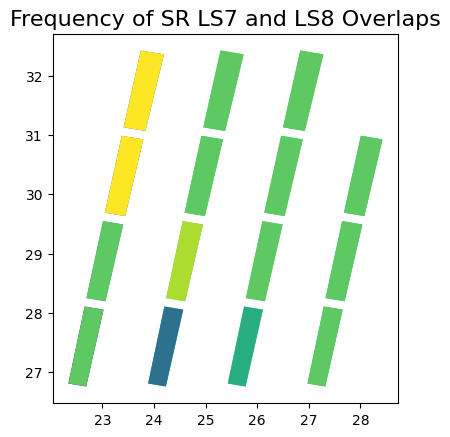

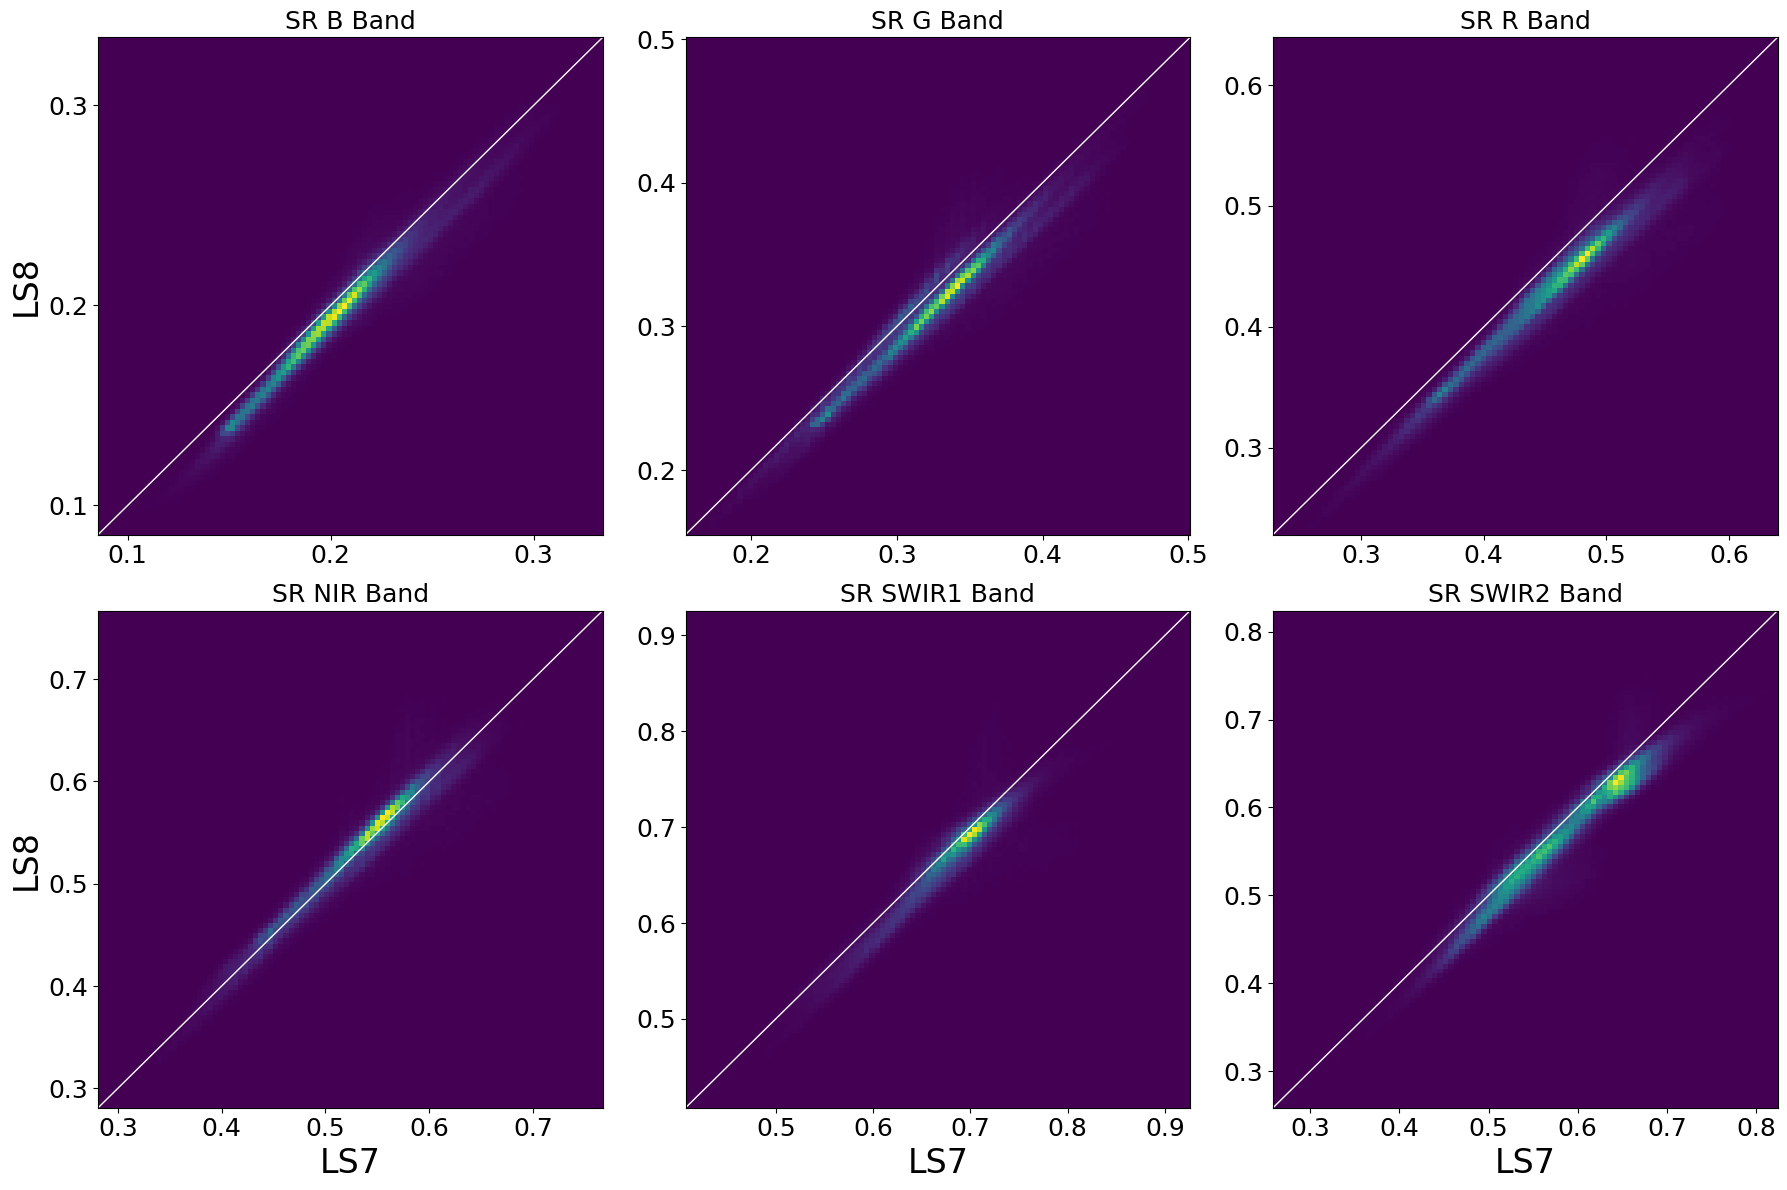


OLS
B: LS8 = 1.0071LS7 + -0.0097
G: LS8 = 0.9449LS7 + 0.0063
R: LS8 = 0.9313LS7 + 0.0065
NIR: LS8 = 0.9564LS7 + 0.0253
SWIR1: LS8 = 0.9155LS7 + 0.0448
SWIR2: LS8 = 0.9316LS7 + 0.024

TheilSen
B: LS8 = 1.0363LS7 + -0.0153
G: LS8 = 0.9625LS7 + -0.0003
R: LS8 = 0.9529LS7 + -0.0028
NIR: LS8 = 0.9828LS7 + 0.0129
SWIR1: LS8 = 0.9771LS7 + 0.0041
SWIR2: LS8 = 0.9406LS7 + 0.0188

RMA
B: LS8 = 0.9667LS7 + -0.0015
G: LS8 = 0.958LS7 + 0.002
R: LS8 = 0.9564LS7 + -0.0049
NIR: LS8 = 0.9472LS7 + 0.0302
SWIR1: LS8 = 0.8956LS7 + 0.0583
SWIR2: LS8 = 0.954LS7 + 0.0109


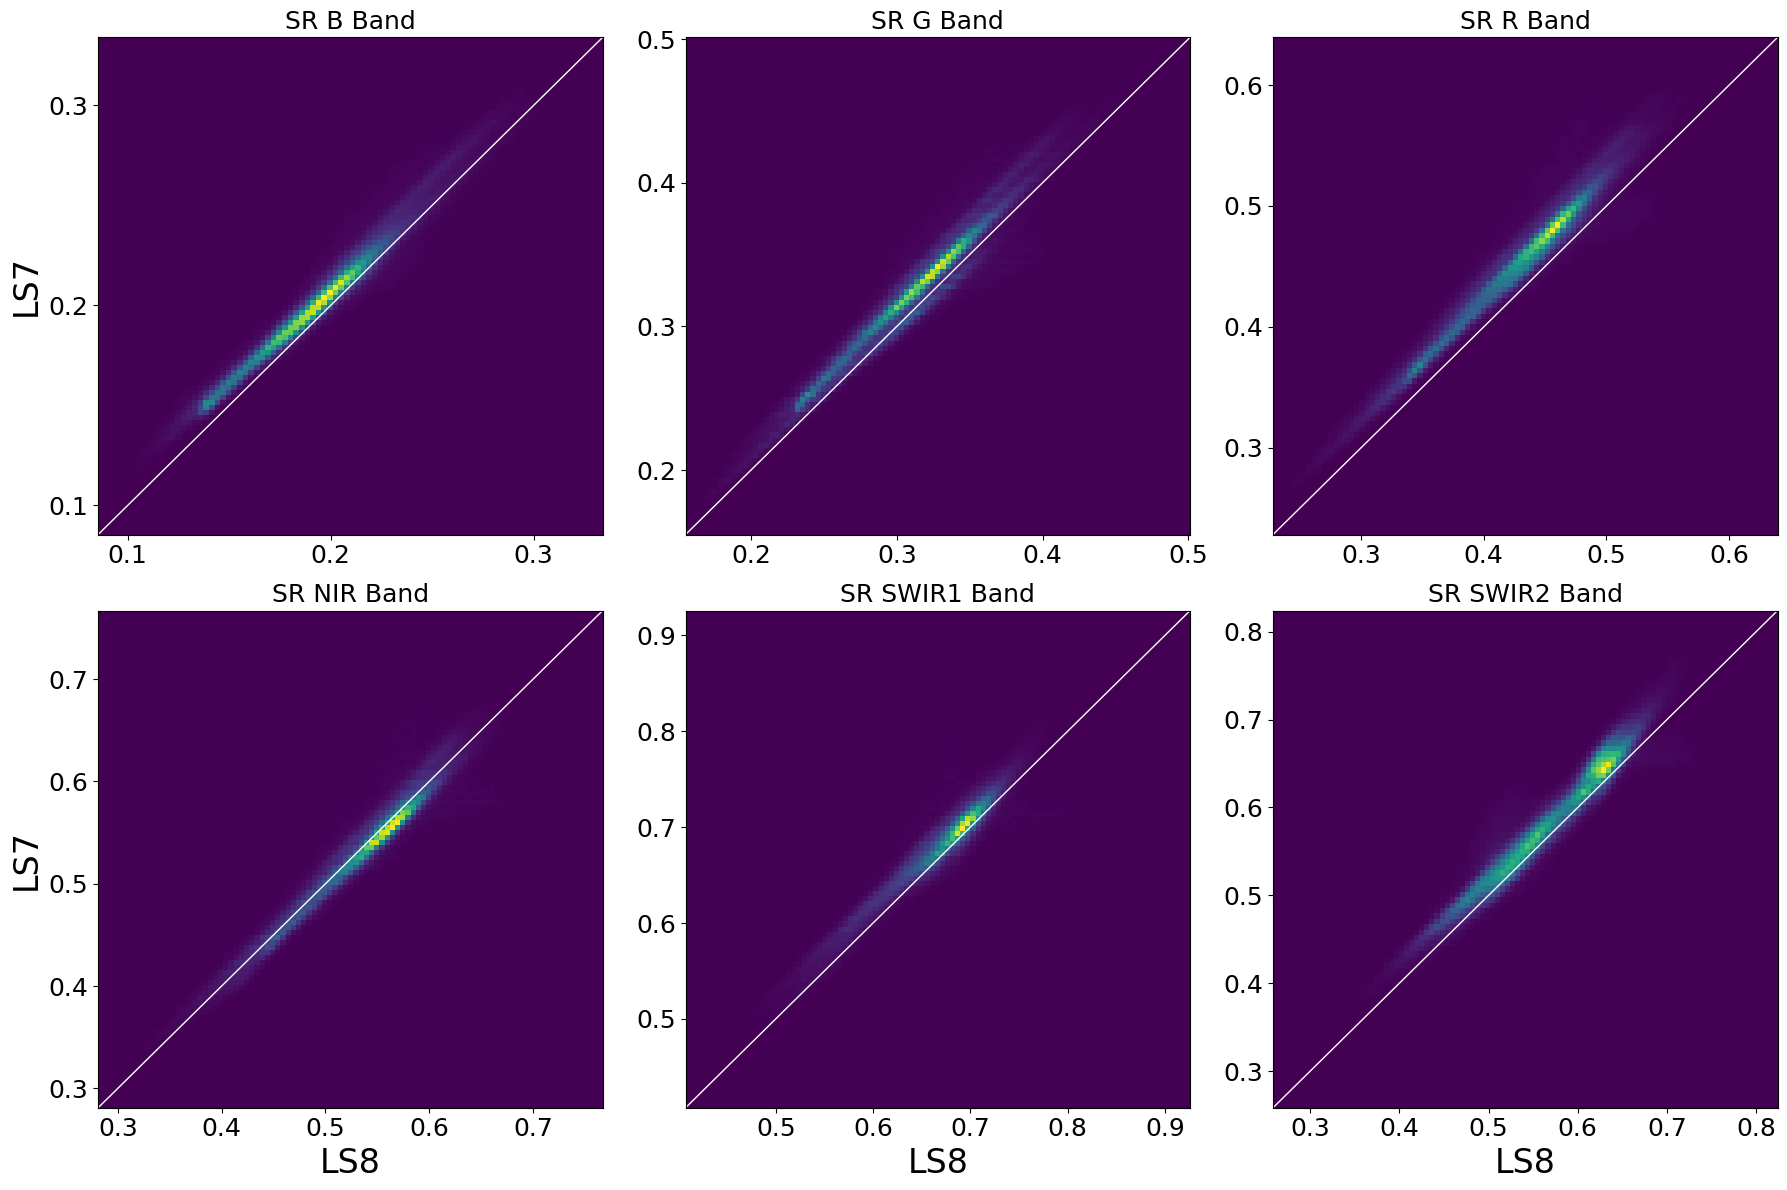


OLS
B: LS7 = 0.928LS8 + 0.0224
G: LS7 = 0.9713LS8 + 0.0206
R: LS7 = 0.9822LS8 + 0.0323
NIR: LS7 = 0.9382LS8 + 0.0311
SWIR1: LS7 = 0.8761LS8 + 0.0953
SWIR2: LS7 = 0.977LS8 + 0.0288

TheilSen
B: LS7 = 0.9244LS8 + 0.0224
G: LS7 = 0.9936LS8 + 0.0142
R: LS7 = 1.0019LS8 + 0.0229
NIR: LS7 = 0.9647LS8 + 0.0149
SWIR1: LS7 = 0.9164LS8 + 0.0672
SWIR2: LS7 = 1.0033LS8 + 0.0137

RMA
B: LS7 = 0.9667LS8 + 0.0148
G: LS7 = 0.958LS8 + 0.0247
R: LS7 = 0.9564LS8 + 0.0434
NIR: LS7 = 0.9472LS8 + 0.0263
SWIR1: LS7 = 0.8956LS8 + 0.0823
SWIR2: LS7 = 0.954LS8 + 0.0418


In [10]:
# 1. Running LEOHS
WRS_gdf,full_AOI=create_WRS_gdf(Aoi_shp_path, wrs_shp_path) #this has all combinations of L+R overlaps for every WRS Tile
full_AOI,strips=split_aoi_into_strips(full_AOI)
overlap_df,frequency_gdf=create_overlap_df(harmonization_order,full_AOI,strips)
Sample_points_gdf,overlap_points_gdf=run_workflow(full_AOI,sample_points_n,frequency_gdf)
overlap_imgs_df=create_img_df(overlap_df) #creates a df up to Max_img_samples per unique overlap
unique_row_path_list=get_unique_combinations_as_dicts(overlap_df) #makes a list of all the unique overlaps
big_gdf=create_big_gdf(unique_row_path_list) #samples points in images found in overlap locations, filters out invalid pixels
harmonization_order=[LS7,LS8]
process_all_regressions(big_gdf, Regression_types) #regresses, then plots data and prints equations
harmonization_order=[LS8,LS7]
process_all_regressions(big_gdf, Regression_types) #regresses, then plots data and prints equations

No need for splitting. Starting timer and proceeding.
SR imagery datasets
GEE filtering completed in 10.4sec
Initial points generated, ensuring they are in WRS overlaps
Processed in 112.55sec
Sampling points in GEE imagery
GEE pixel sampling completed in: 4:17:54.097630


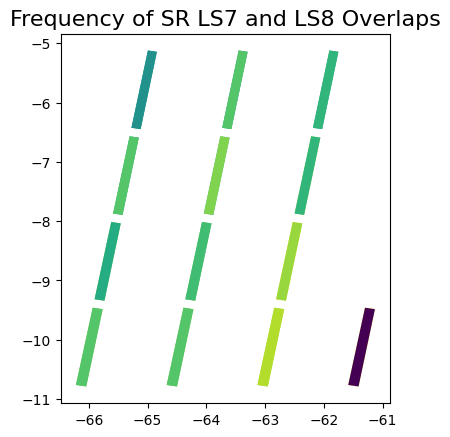

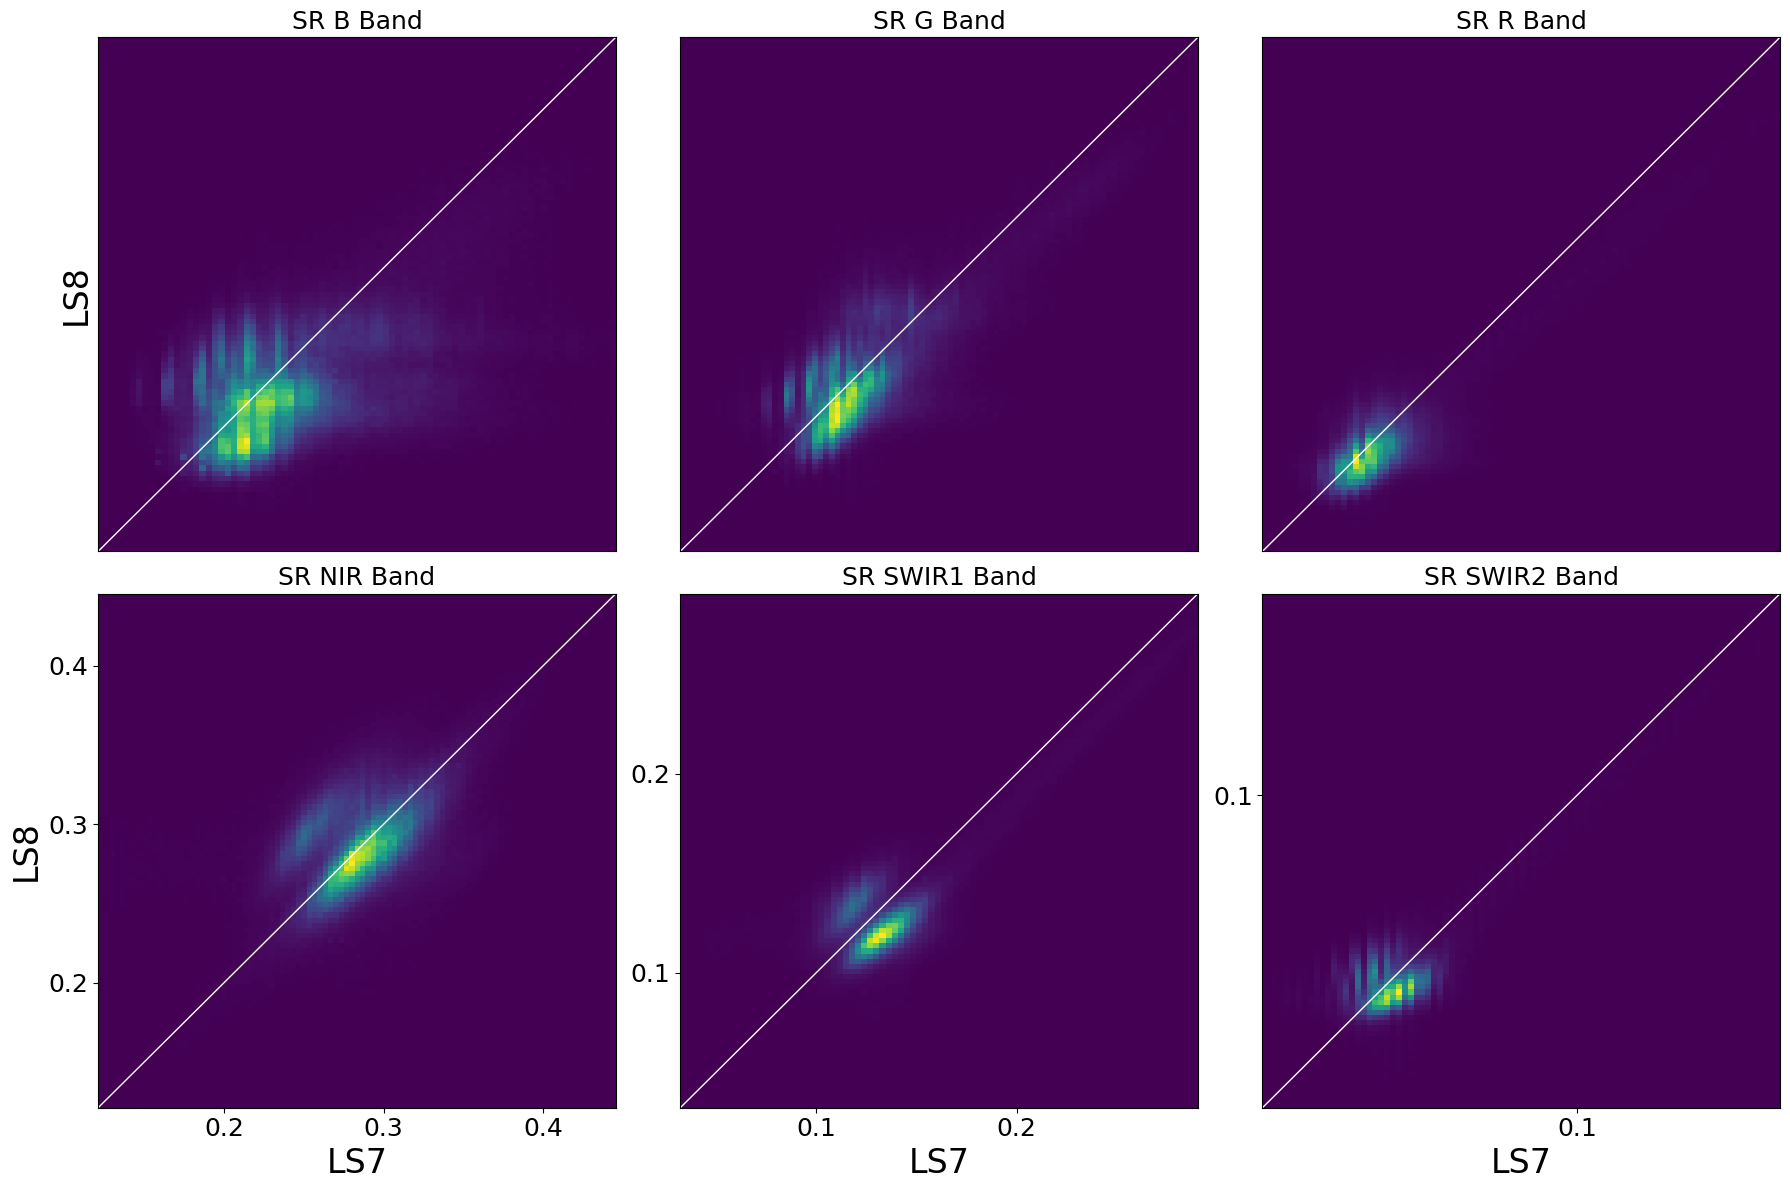


OLS
B: LS8 = 0.3393LS7 + 0.0118
G: LS8 = 0.6809LS7 + 0.0113
R: LS8 = 0.7411LS7 + 0.0049
NIR: LS8 = 0.4433LS7 + 0.1604
SWIR1: LS8 = 0.6799LS7 + 0.0369
SWIR2: LS8 = 0.7749LS7 + 0.0101

TheilSen
B: LS8 = 0.2957LS7 + 0.012
G: LS8 = 0.6635LS7 + 0.0116
R: LS8 = 0.5677LS7 + 0.0088
NIR: LS8 = 0.4713LS7 + 0.1513
SWIR1: LS8 = 0.3511LS7 + 0.077
SWIR2: LS8 = 0.3275LS7 + 0.0293


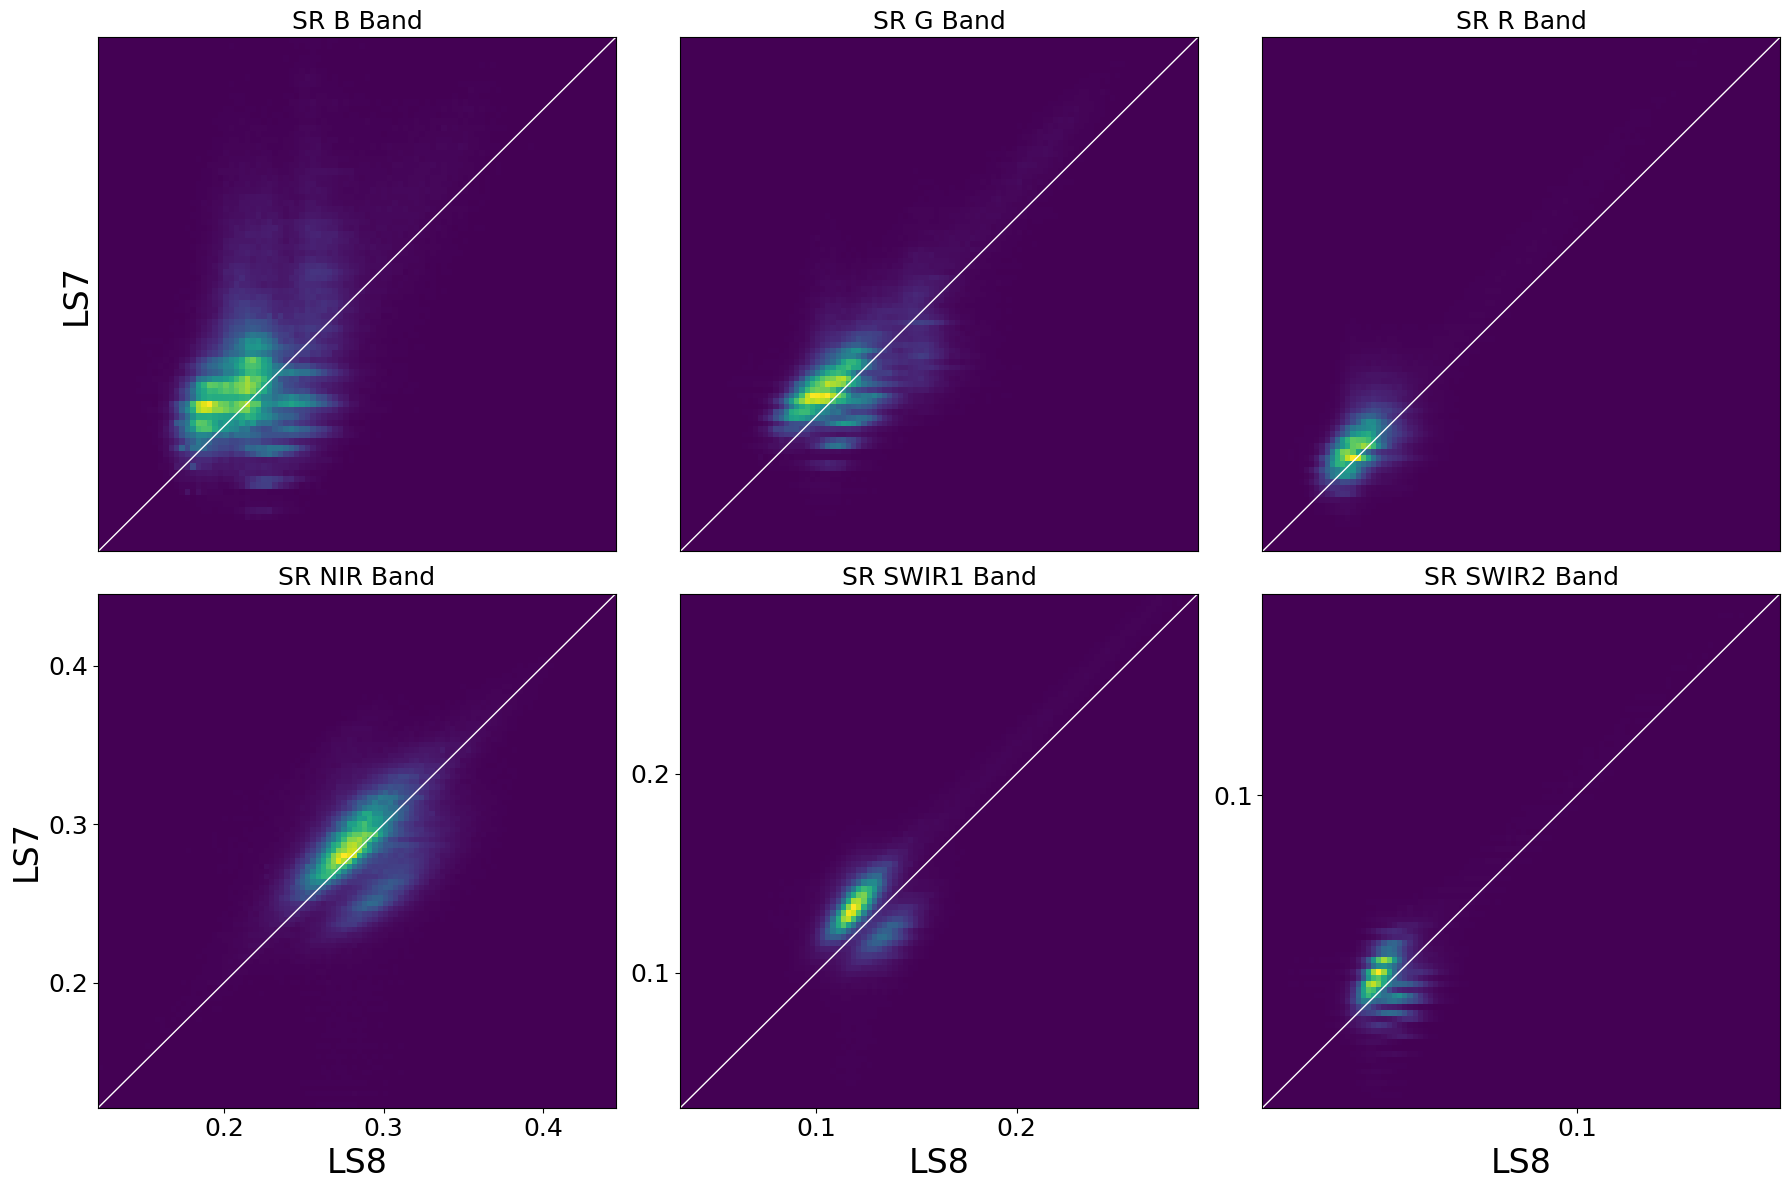


OLS
B: LS7 = 0.7037LS8 + 0.008
G: LS7 = 0.7509LS8 + 0.0103
R: LS7 = 0.9745LS8 + 0.0025
NIR: LS7 = 0.5194LS8 + 0.1361
SWIR1: LS7 = 0.838LS8 + 0.0274
SWIR2: LS7 = 0.9177LS8 + 0.0053

TheilSen
B: LS7 = 0.5713LS8 + 0.0094
G: LS7 = 0.5834LS8 + 0.0163
R: LS7 = 0.7405LS8 + 0.0075
NIR: LS7 = 0.5458LS8 + 0.131
SWIR1: LS7 = 0.5222LS8 + 0.0681
SWIR2: LS7 = 0.5273LS8 + 0.0239
Initial points generated, ensuring they are in WRS overlaps
Processed in 97.18sec
Sampling points in GEE imagery
GEE pixel sampling completed in: 5:07:38.604457


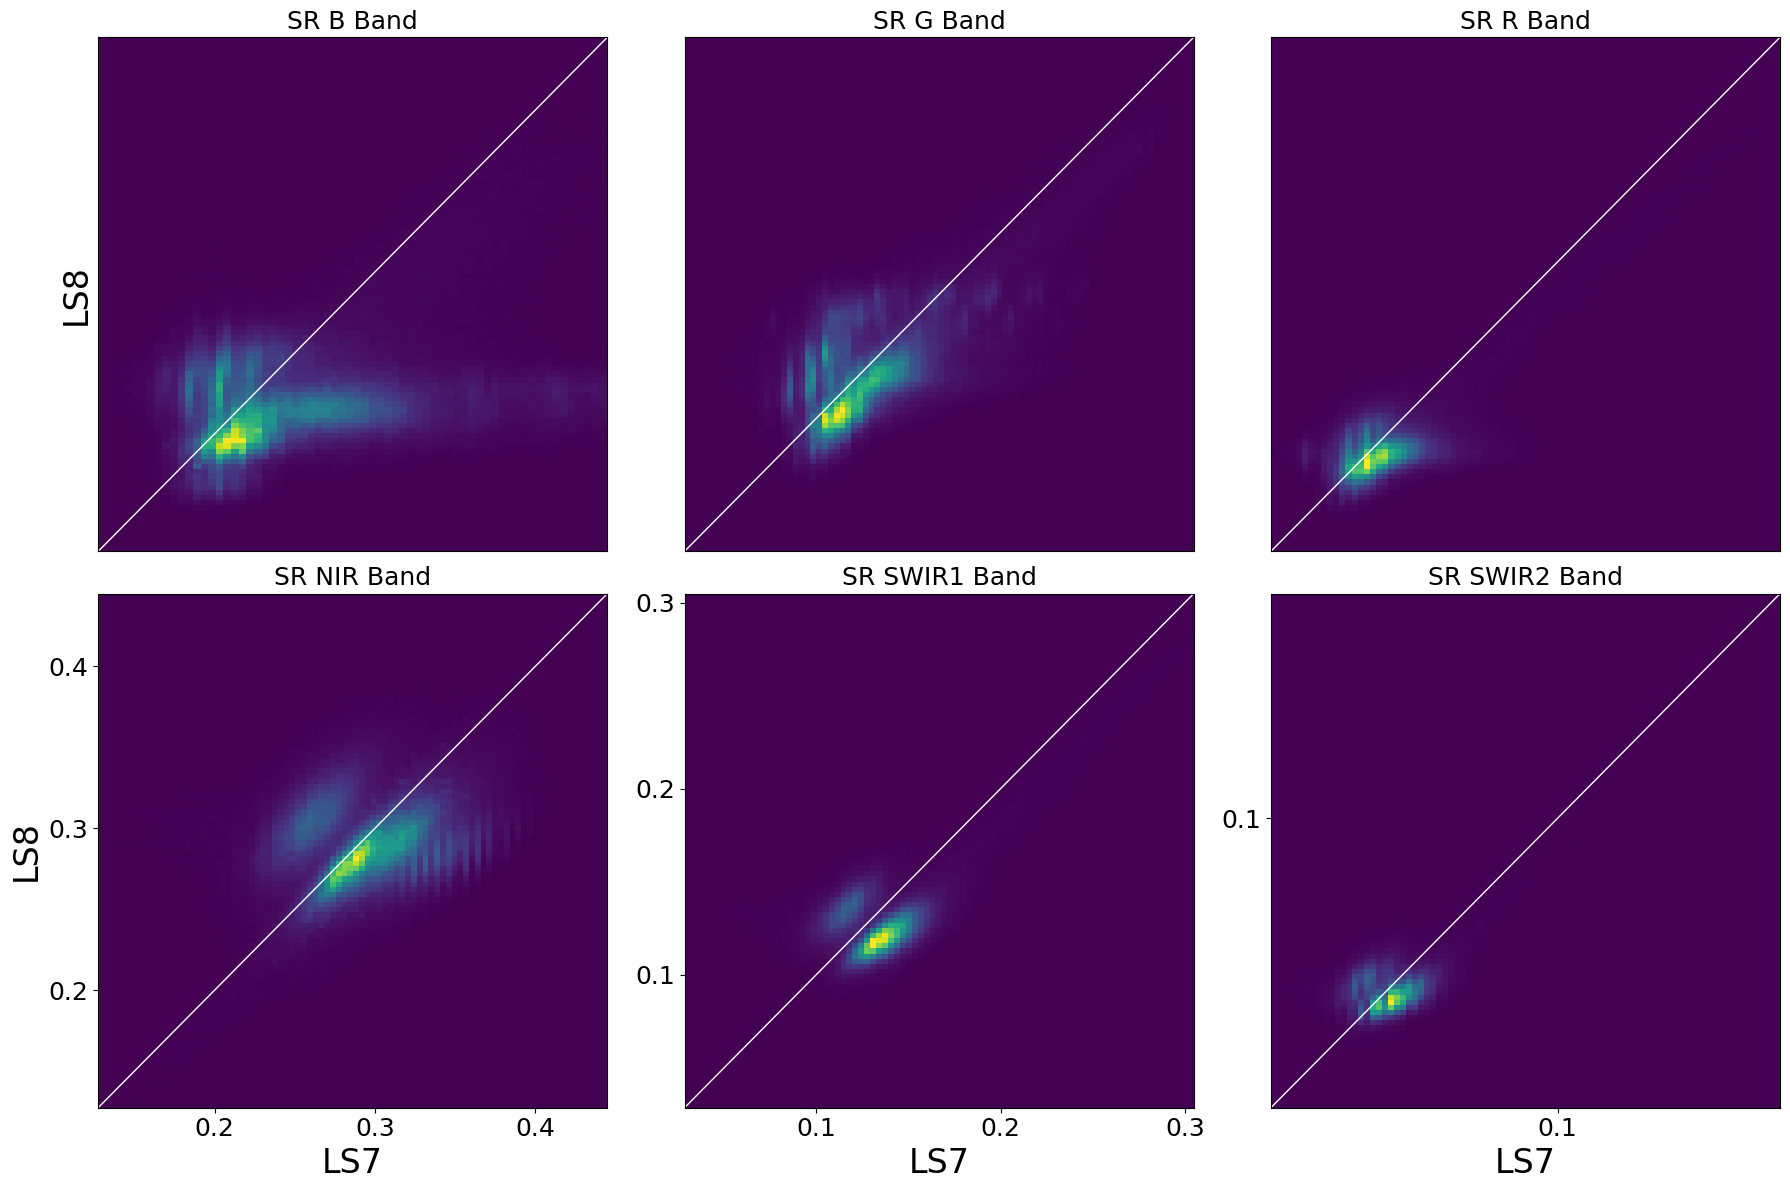


OLS
B: LS8 = 0.1737LS7 + 0.0155
G: LS8 = 0.5395LS7 + 0.0179
R: LS8 = 0.644LS7 + 0.0076
NIR: LS8 = 0.2576LS7 + 0.2142
SWIR1: LS8 = 0.6284LS7 + 0.0428
SWIR2: LS8 = 0.7385LS7 + 0.0117

TheilSen
B: LS8 = 0.1445LS7 + 0.0147
G: LS8 = 0.4906LS7 + 0.0189
R: LS8 = 0.3135LS7 + 0.015
NIR: LS8 = 0.2359LS7 + 0.2185
SWIR1: LS8 = 0.3213LS7 + 0.0805
SWIR2: LS8 = 0.3087LS7 + 0.0304


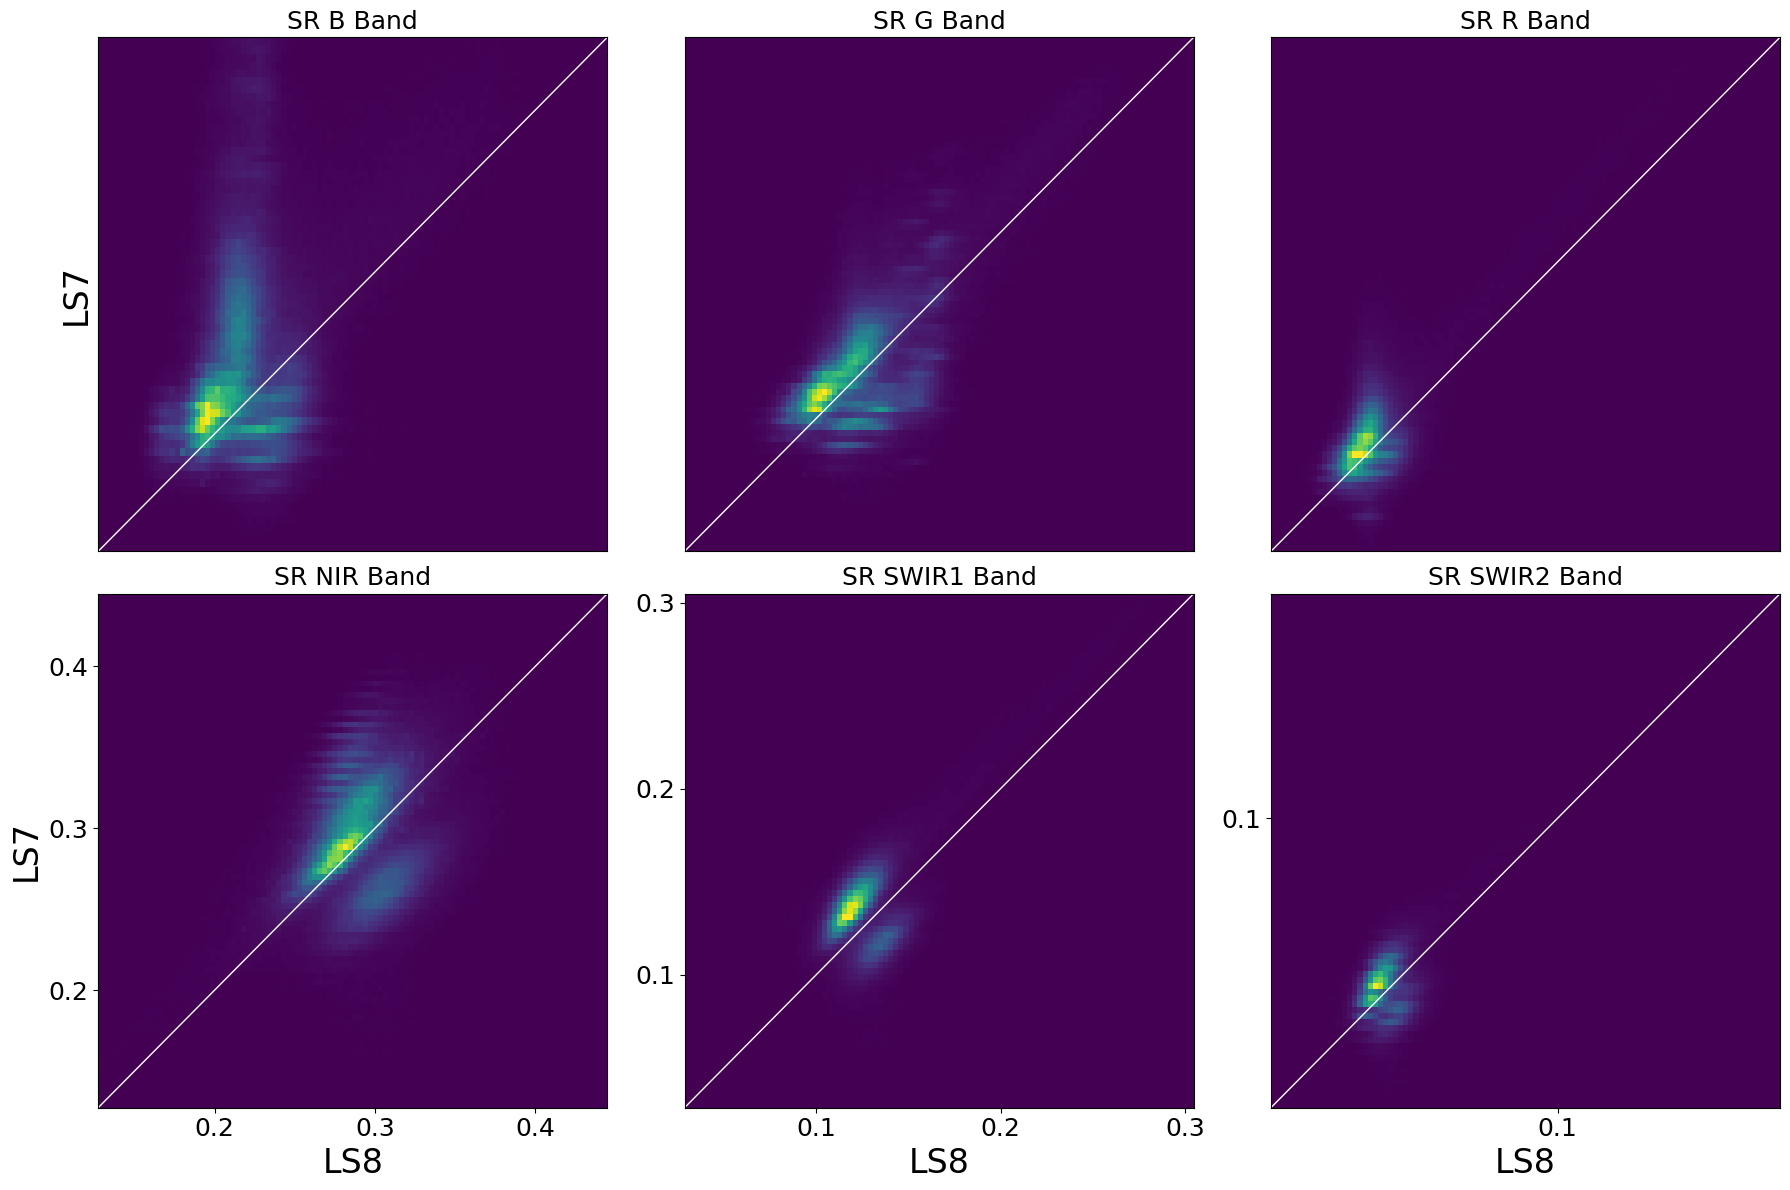


OLS
B: LS7 = 0.7509LS8 + 0.0107
G: LS7 = 0.8072LS8 + 0.0088
R: LS7 = 1.0399LS8 + 0.0013
NIR: LS7 = 0.4408LS8 + 0.1663
SWIR1: LS7 = 0.897LS8 + 0.0221
SWIR2: LS7 = 1.0141LS8 + 0.0011

TheilSen
B: LS7 = 0.6152LS8 + 0.0106
G: LS7 = 0.6936LS8 + 0.013
R: LS7 = 0.7233LS8 + 0.0083
NIR: LS7 = 0.4772LS8 + 0.1568
SWIR1: LS7 = 0.5739LS8 + 0.0652
SWIR2: LS7 = 0.6266LS8 + 0.0197


In [8]:
#2. Running LEOHS multiple times on your AOI
Repeats=2 #number of times you want to run LEOHS
WRS_gdf,full_AOI=create_WRS_gdf(Aoi_shp_path, wrs_shp_path) #this has all combinations of L+R overlaps for every WRS Tile
full_AOI,strips=split_aoi_into_strips(full_AOI)
overlap_df,frequency_gdf=create_overlap_df(harmonization_order,full_AOI,strips)
Save_folder_path_original=Save_folder_path
for value in range(Repeats):
    Save_folder_path=f'{Save_folder_path_original}{value+1}'
    create_save_path()
    Sample_points_gdf,overlap_points_gdf=run_workflow(full_AOI,sample_points_n,frequency_gdf)
    overlap_imgs_df=create_img_df(overlap_df) #creates a df up to Max_img_samples per unique overlap
    unique_row_path_list=get_unique_combinations_as_dicts(overlap_df) #makes a list of all the unique overlaps
    big_gdf=create_big_gdf(unique_row_path_list) #samples points in images found in overlap locations, filters out invalid pixels
    harmonization_order=[LS7,LS8]
    process_all_regressions(big_gdf, Regression_types) #regresses, then plots data and prints equations
    harmonization_order=[LS8,LS7]
    process_all_regressions(big_gdf, Regression_types) #regresses, then plots data and prints equations

### DEEP LEOHS Versions

In [32]:
#You need to run this inorder to use DEEP LEOHS
def split_gdf_into_equal_parts(Sample_points_gdf, num_parts=10):
    # Shuffle the GeoDataFrame
    shuffled_gdf = Sample_points_gdf.sample(frac=1).reset_index(drop=True)
    gdf_list = np.array_split(shuffled_gdf, num_parts)
    return gdf_list

No need for splitting. Starting timer and proceeding.
SR imagery datasets
GEE filtering completed in 9.55sec
Initial points generated, ensuring they are in WRS overlaps
Processed in 80.49sec
Sampling 10 times
Sampling points in GEE imagery
GEE pixel sampling completed in: 0:41:39.404227
Sampling points in GEE imagery
GEE pixel sampling completed in: 0:47:11.312120
Sampling points in GEE imagery
GEE pixel sampling completed in: 0:40:19.257664
Sampling points in GEE imagery
GEE pixel sampling completed in: 0:48:03.406540
Sampling points in GEE imagery
GEE pixel sampling completed in: 0:37:49.082458
Sampling points in GEE imagery
GEE pixel sampling completed in: 0:43:45.668366
Sampling points in GEE imagery
GEE pixel sampling completed in: 0:40:15.558053
Sampling points in GEE imagery
GEE pixel sampling completed in: 0:36:37.051338
Sampling points in GEE imagery
GEE pixel sampling completed in: 0:42:58.467817
Sampling points in GEE imagery
GEE pixel sampling completed in: 0:47:36.718884


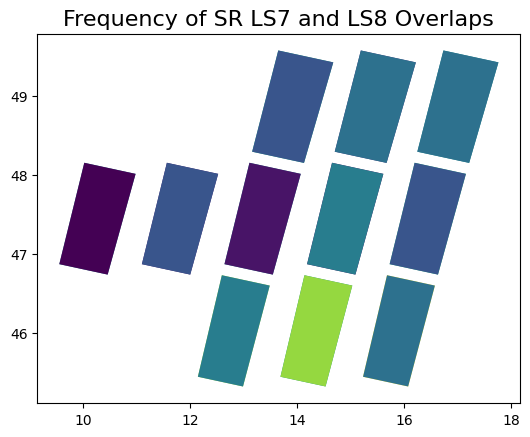

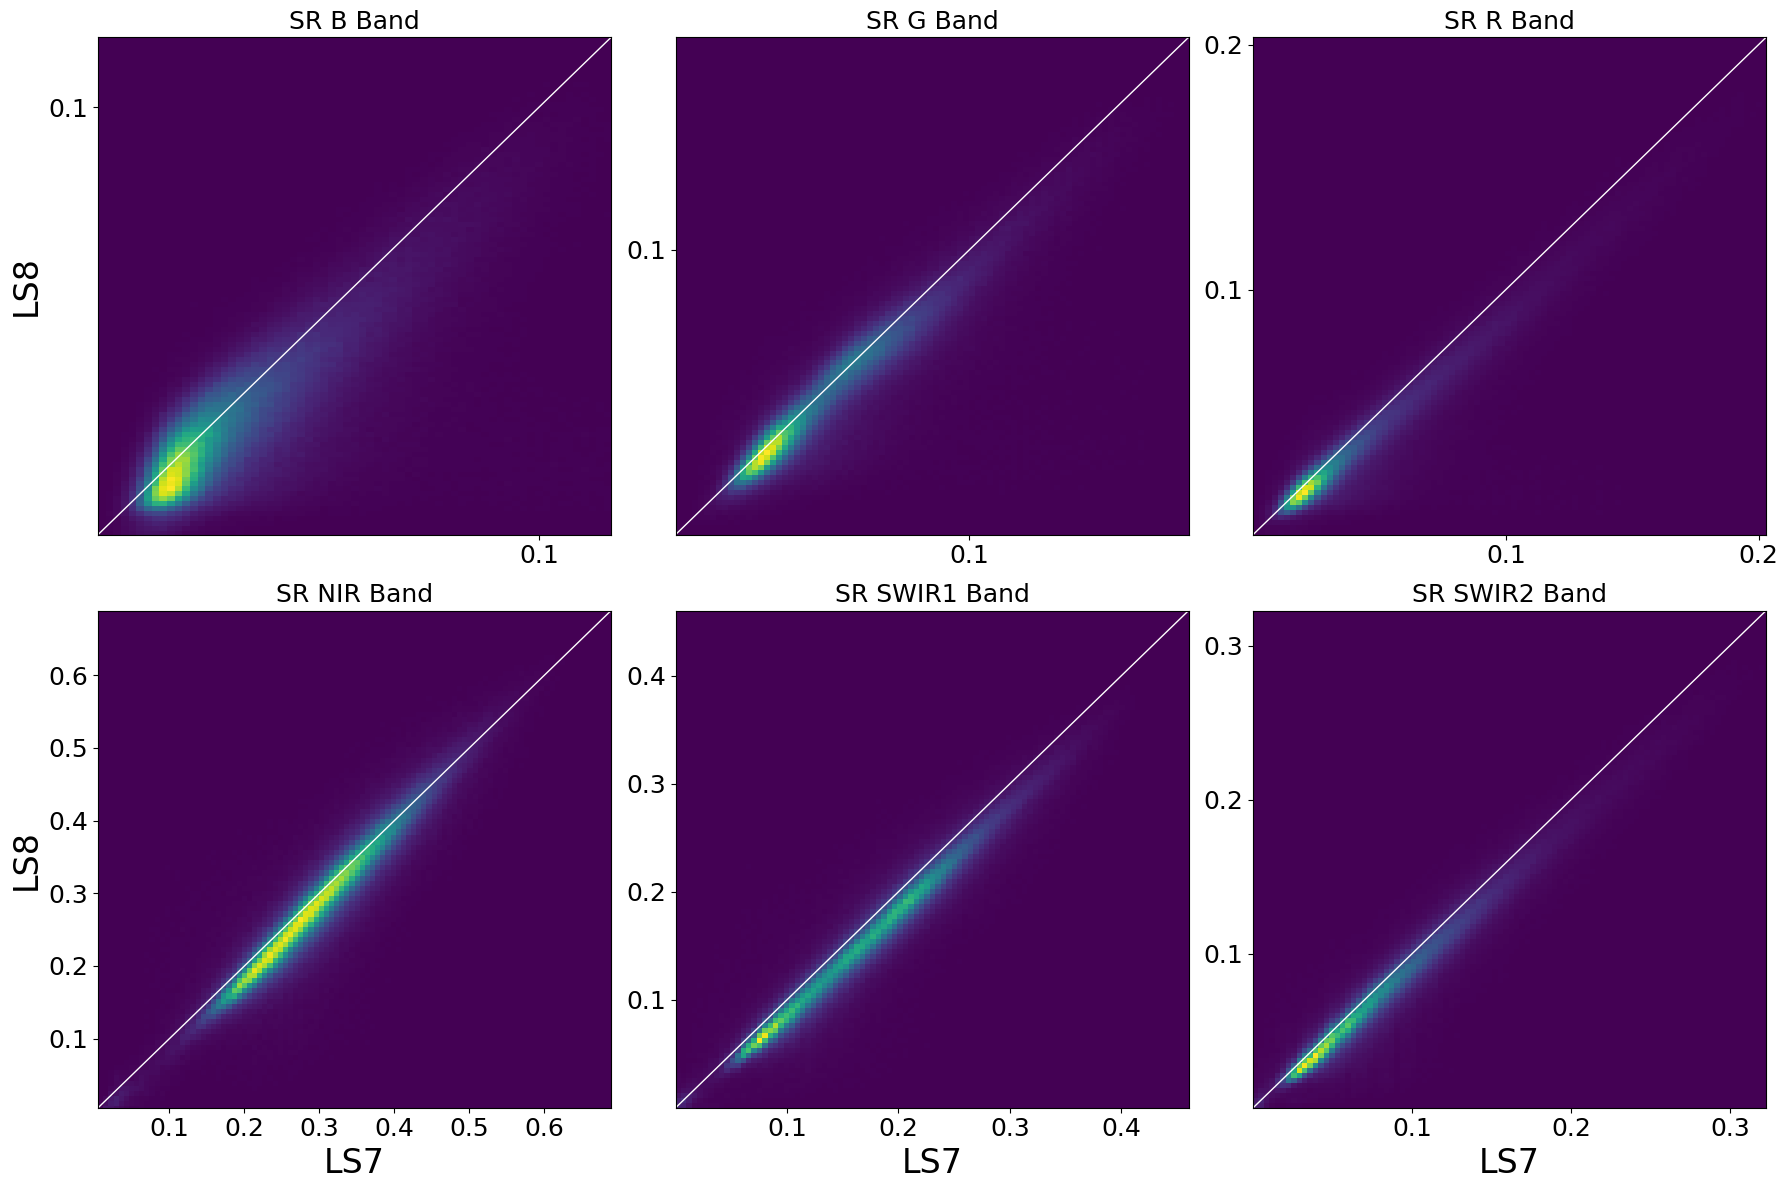


OLS
B: LS8 = 0.5149LS7 + 0.0097
G: LS8 = 0.7126LS7 + 0.0104
R: LS8 = 0.7709LS7 + 0.0029
NIR: LS8 = 0.9773LS7 + -0.0076
SWIR1: LS8 = 0.9002LS7 + 0.0003
SWIR2: LS8 = 0.8831LS7 + 0.0019

TheilSen
B: LS8 = 0.7262LS7 + 0.0042
G: LS8 = 0.8603LS7 + 0.0037
R: LS8 = 0.8153LS7 + 0.0023
NIR: LS8 = 1.0244LS7 + -0.0211
SWIR1: LS8 = 0.9408LS7 + -0.0066
SWIR2: LS8 = 0.9123LS7 + -0.0004


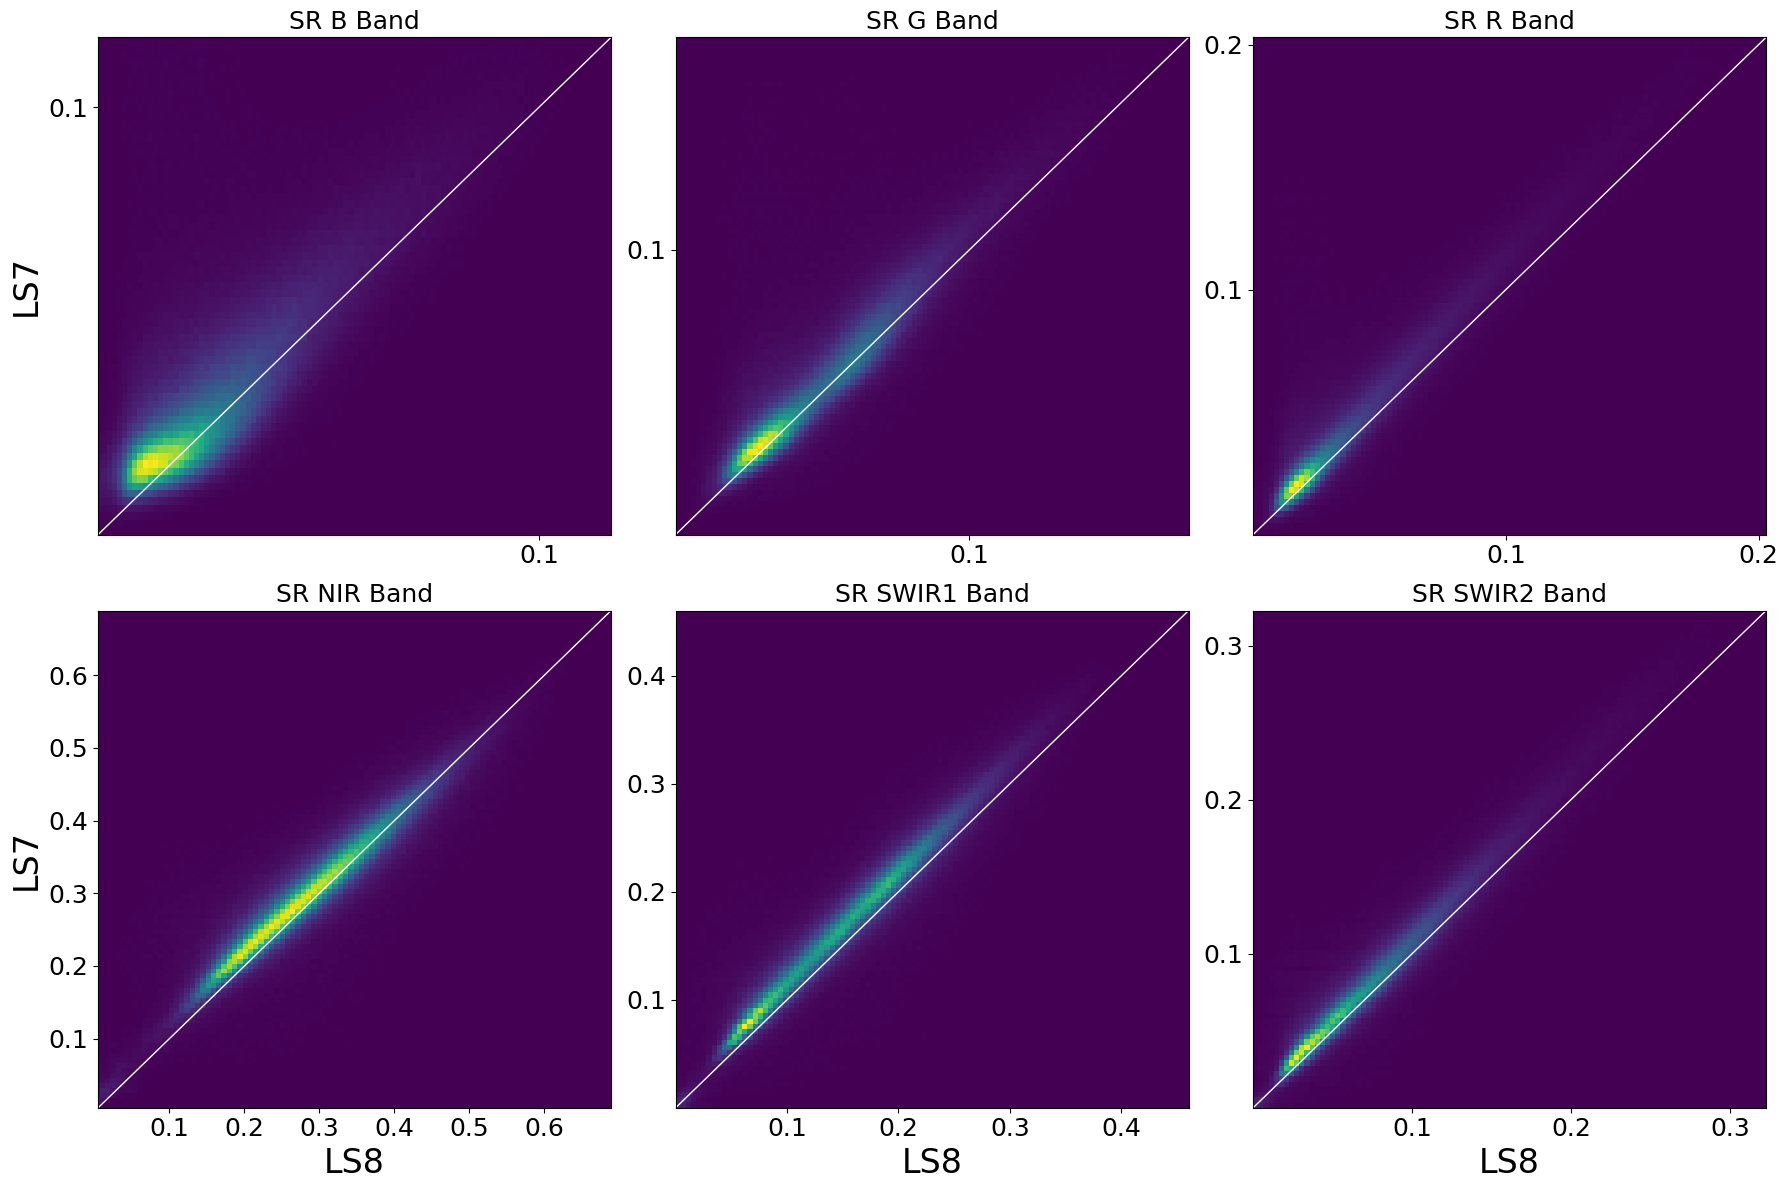


OLS
B: LS7 = 0.8999LS8 + 0.0111
G: LS7 = 0.9296LS8 + 0.0105
R: LS7 = 1.0142LS8 + 0.0087
NIR: LS7 = 0.8333LS8 + 0.0623
SWIR1: LS7 = 0.9509LS8 + 0.0248
SWIR2: LS7 = 0.9927LS8 + 0.0095

TheilSen
B: LS7 = 0.9044LS8 + 0.0072
G: LS7 = 0.9813LS8 + 0.0046
R: LS7 = 1.0658LS8 + 0.003
NIR: LS7 = 0.8757LS8 + 0.0488
SWIR1: LS7 = 0.9877LS8 + 0.0183
SWIR2: LS7 = 1.0231LS8 + 0.0056


In [33]:
# 3. Running DEEP LEOHS
WRS_gdf,full_AOI=create_WRS_gdf(Aoi_shp_path, wrs_shp_path) #this has all combinations of L+R overlaps for every WRS Tile
full_AOI,strips=split_aoi_into_strips(full_AOI)
overlap_df,frequency_gdf=create_overlap_df(harmonization_order,full_AOI,strips)
Sample_points_gdf,overlap_points_gdf=run_workflow(full_AOI,sample_points_n,frequency_gdf)
gdfs=split_gdf_into_equal_parts(overlap_points_gdf, num_parts=10)
all_big_gdf=gpd.GeoDataFrame()
Save_data_original = Save_data
print(f'Sampling {len(gdfs)} times')
for overlap_points_gdf in gdfs:
    overlap_imgs_df=create_img_df(overlap_df) #creates a df up to Max_img_samples per unique overlap
    unique_row_path_list=get_unique_combinations_as_dicts(overlap_df) #makes a list of all the unique overlaps
    Save_data= False
    big_gdf=create_big_gdf(unique_row_path_list) #samples points in images found in overlap locations, filters out invalid pixels
    all_big_gdf = pd.concat([all_big_gdf, big_gdf], ignore_index=True)
Save_data = Save_data_original
if Save_data==True:
    dtype=toa_or_sr(LS8,LS7)
    col_names=get_var_names_from_list(harmonization_order)
    all_big_gdf.to_file(f'{Save_folder_path}\\{dtype}_Landsatsamples.shp', driver='ESRI Shapefile')
    all_big_gdf.to_csv(f'{Save_folder_path}\\{dtype}_Landsatsamples.csv')
harmonization_order=[LS7,LS8]
process_all_regressions(all_big_gdf, Regression_types) #regresses, then plots data and prints equations
harmonization_order=[LS8,LS7]
process_all_regressions(all_big_gdf, Regression_types) #regresses, then plots data and prints equations

No need for splitting. Starting timer and proceeding.
SR imagery datasets
GEE filtering completed in 11.7sec
Initial points generated, ensuring they are in WRS overlaps
Processed in 10.78sec
Sampling points in GEE imagery
GEE pixel sampling completed in: 0:01:01.801185
Sampling points in GEE imagery
GEE pixel sampling completed in: 0:00:57.097830
Sampling points in GEE imagery
GEE pixel sampling completed in: 0:00:55.678739
Sampling points in GEE imagery
GEE pixel sampling completed in: 0:00:55.450905
Sampling points in GEE imagery
GEE pixel sampling completed in: 0:00:52.996663
Sampling points in GEE imagery
GEE pixel sampling completed in: 0:00:56.426036
Sampling points in GEE imagery
GEE pixel sampling completed in: 0:00:50.209939
Sampling points in GEE imagery
GEE pixel sampling completed in: 0:00:51.019078
Sampling points in GEE imagery
GEE pixel sampling completed in: 0:00:50.497922
Sampling points in GEE imagery
GEE pixel sampling completed in: 0:00:49.111302


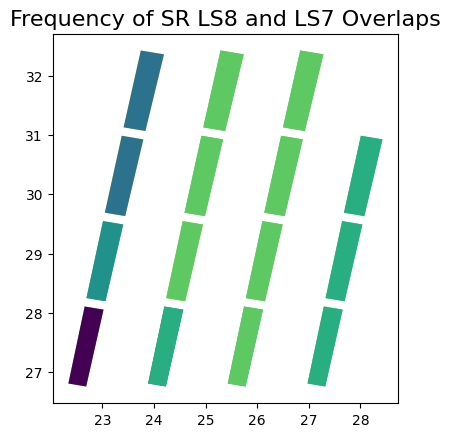

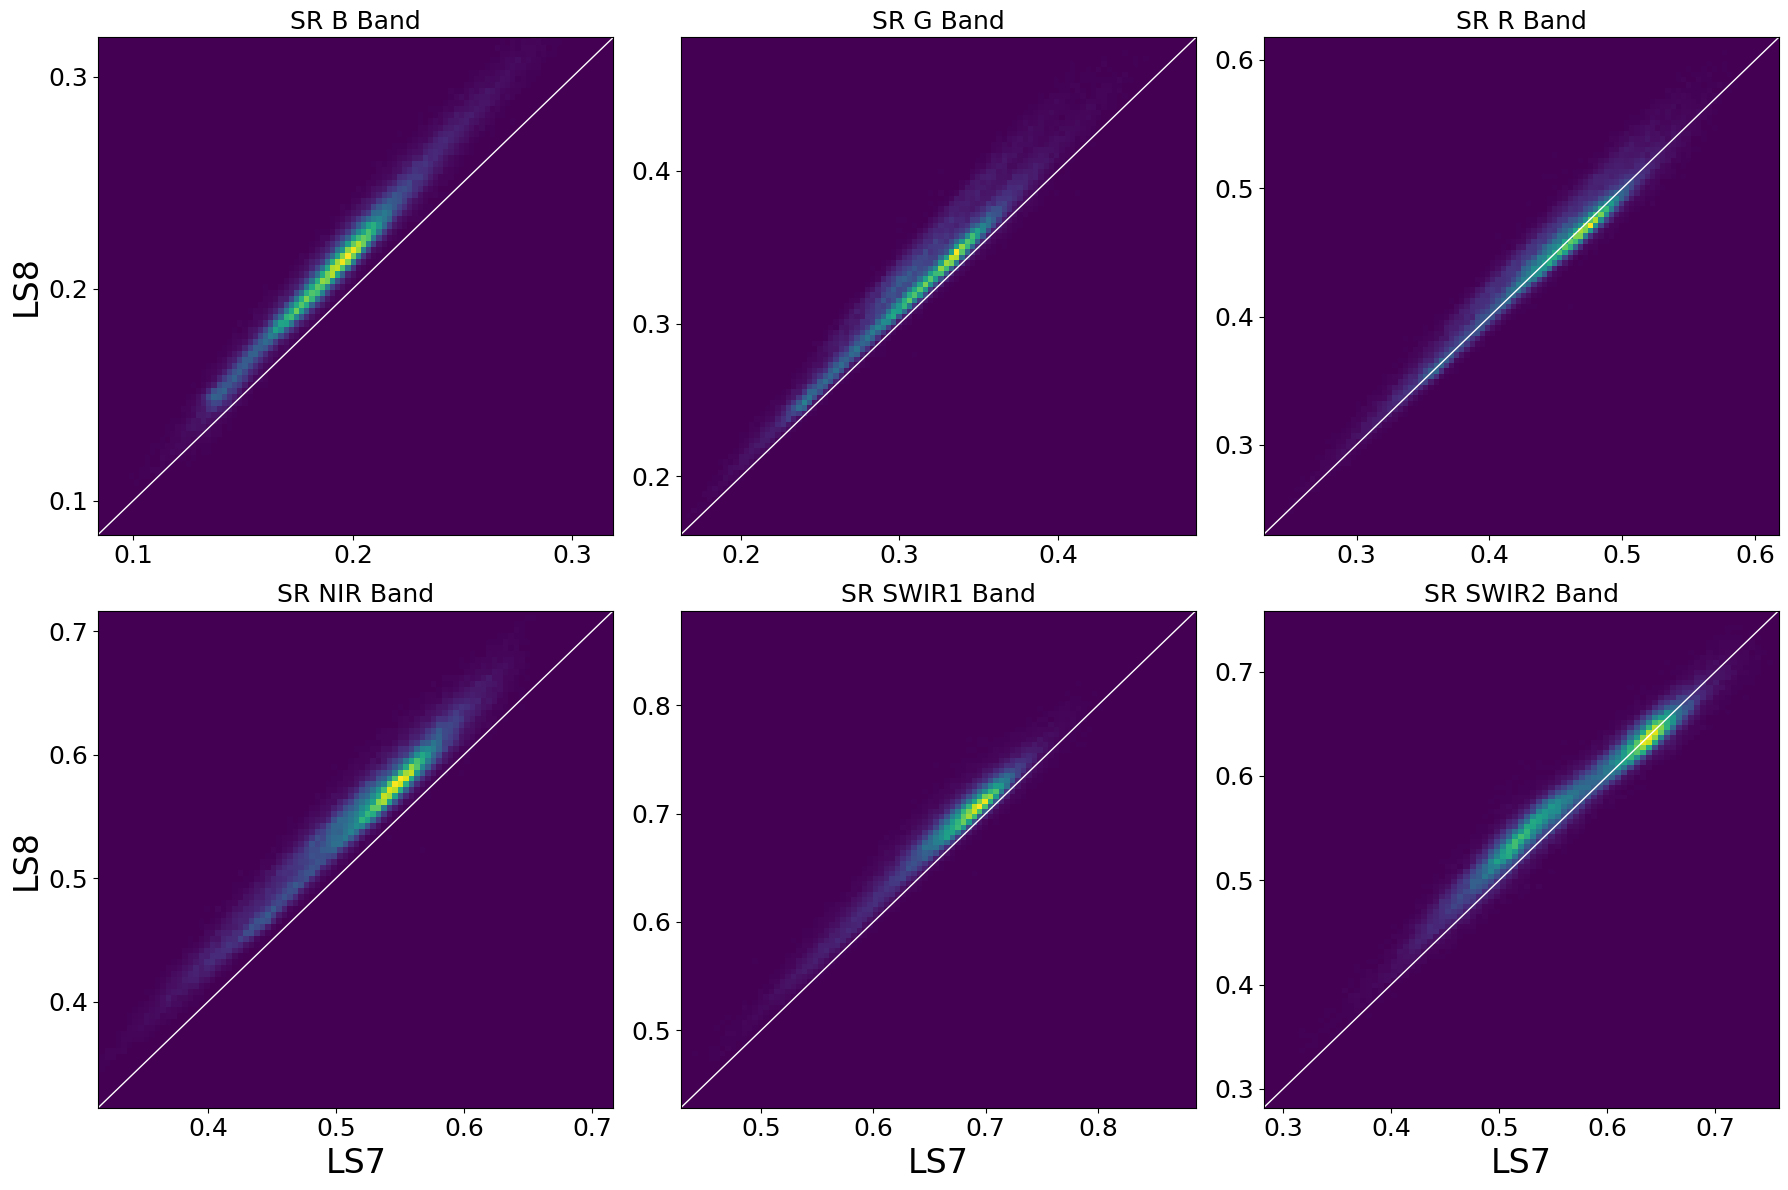


OLS
B: LS8 = 1.132LS7 + -0.0064
G: LS8 = 1.0322LS7 + 0.0059
R: LS8 = 0.9666LS7 + 0.0193
NIR: LS8 = 0.9806LS7 + 0.0434
SWIR1: LS8 = 0.9349LS7 + 0.0617
SWIR2: LS8 = 0.8724LS7 + 0.0831

TheilSen
B: LS8 = 1.1236LS7 + -0.0051
G: LS8 = 1.0189LS7 + 0.0066
R: LS8 = 0.9537LS7 + 0.022
NIR: LS8 = 0.9858LS7 + 0.0386
SWIR1: LS8 = 0.9259LS7 + 0.066
SWIR2: LS8 = 0.8666LS7 + 0.0864

RMA
B: LS8 = 0.9816LS7 + 0.0224
G: LS8 = 0.9678LS7 + 0.0259
R: LS8 = 0.9722LS7 + 0.0168
NIR: LS8 = 0.9708LS7 + 0.0485
SWIR1: LS8 = 0.9643LS7 + 0.0422
SWIR2: LS8 = 0.9768LS7 + 0.0237


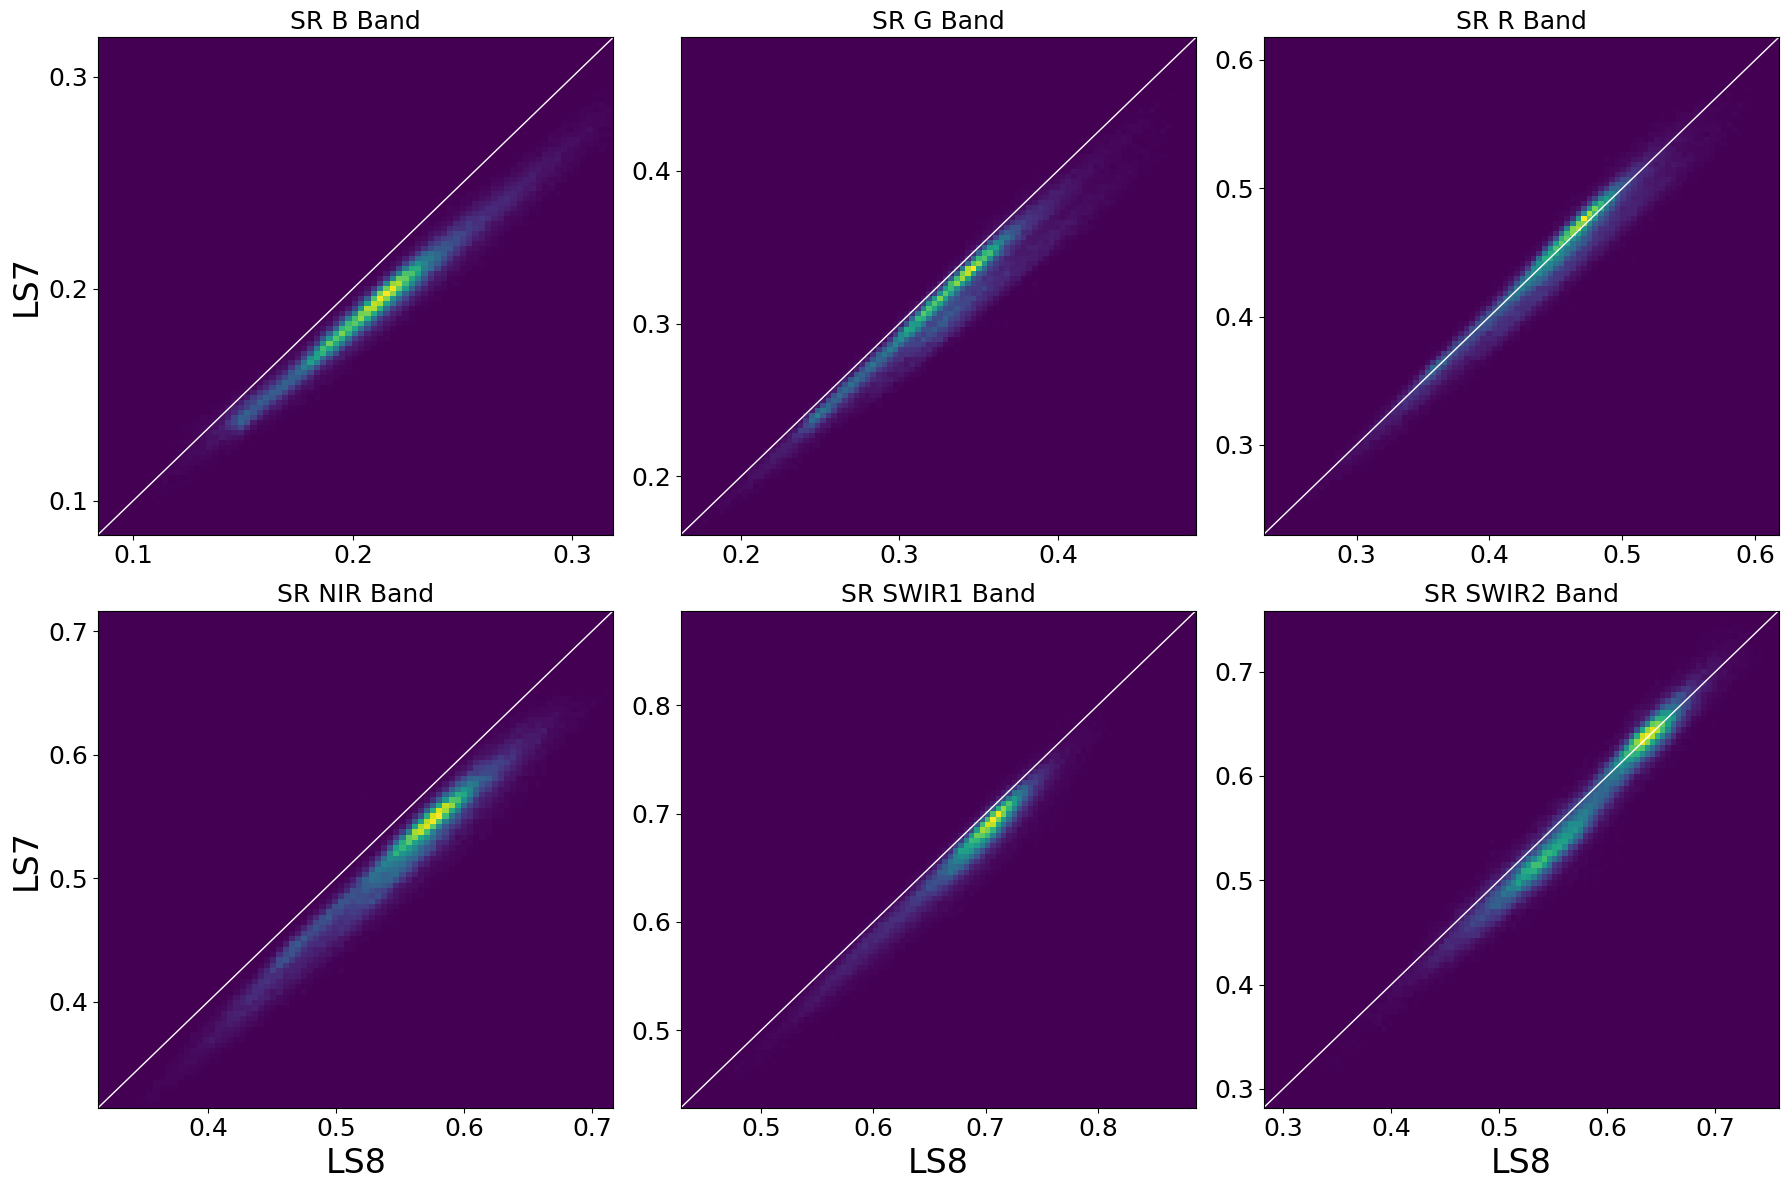


OLS
B: LS7 = 0.8511LS8 + 0.0124
G: LS7 = 0.9073LS8 + 0.0144
R: LS7 = 0.9779LS8 + 0.0052
NIR: LS7 = 0.9611LS8 + -0.0119
SWIR1: LS7 = 0.9945LS8 + -0.0147
SWIR2: LS7 = 1.0936LS8 + -0.0648

TheilSen
B: LS7 = 0.8607LS8 + 0.0106
G: LS7 = 0.9422LS8 + 0.0057
R: LS7 = 1.0004LS8 + -0.0022
NIR: LS7 = 0.9664LS8 + -0.0132
SWIR1: LS7 = 1.0121LS8 + -0.025
SWIR2: LS7 = 1.1042LS8 + -0.0709

RMA
B: LS7 = 0.9816LS8 + -0.015
G: LS7 = 0.9678LS8 + -0.0053
R: LS7 = 0.9722LS8 + 0.0078
NIR: LS7 = 0.9708LS8 + -0.0173
SWIR1: LS7 = 0.9643LS8 + 0.006
SWIR2: LS7 = 0.9768LS8 + 0.0029
Initial points generated, ensuring they are in WRS overlaps
Processed in 11.39sec
Sampling points in GEE imagery
GEE pixel sampling completed in: 0:00:57.615687
Sampling points in GEE imagery
GEE pixel sampling completed in: 0:00:57.082703
Sampling points in GEE imagery
GEE pixel sampling completed in: 0:00:53.497363
Sampling points in GEE imagery
GEE pixel sampling completed in: 0:01:01.677677
Sampling points in GEE imagery
GEE pixel 

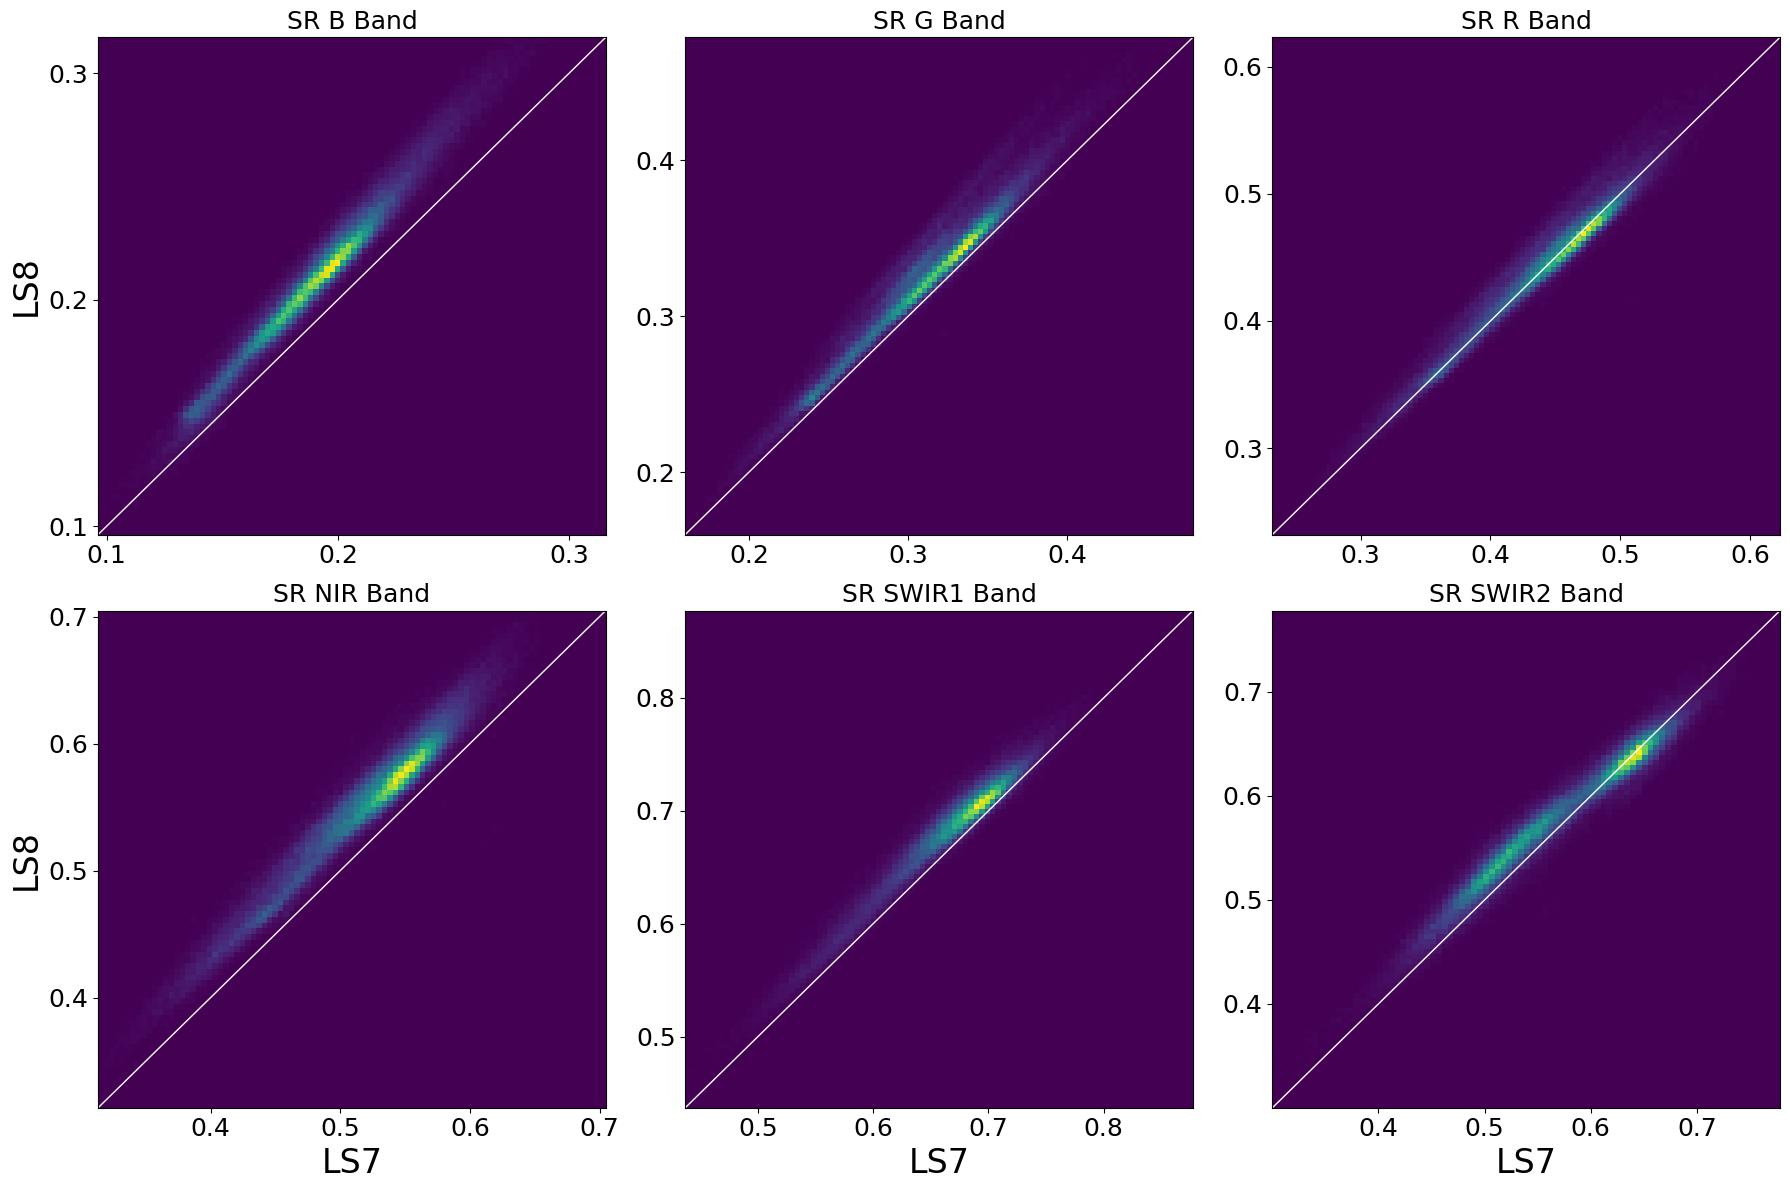


OLS
B: LS8 = 1.1261LS7 + -0.0052
G: LS8 = 1.0234LS7 + 0.0076
R: LS8 = 0.9591LS7 + 0.0218
NIR: LS8 = 0.9794LS7 + 0.0438
SWIR1: LS8 = 0.9281LS7 + 0.0657
SWIR2: LS8 = 0.8591LS7 + 0.0901

TheilSen
B: LS8 = 1.1204LS7 + -0.0046
G: LS8 = 1.0169LS7 + 0.0067
R: LS8 = 0.9575LS7 + 0.0198
NIR: LS8 = 0.9815LS7 + 0.0408
SWIR1: LS8 = 0.9236LS7 + 0.0672
SWIR2: LS8 = 0.8577LS7 + 0.0909

RMA
B: LS8 = 0.9799LS7 + 0.0227
G: LS8 = 0.9694LS7 + 0.0245
R: LS8 = 0.9715LS7 + 0.0163
NIR: LS8 = 0.9679LS7 + 0.0497
SWIR1: LS8 = 0.9607LS7 + 0.044
SWIR2: LS8 = 0.9744LS7 + 0.0244


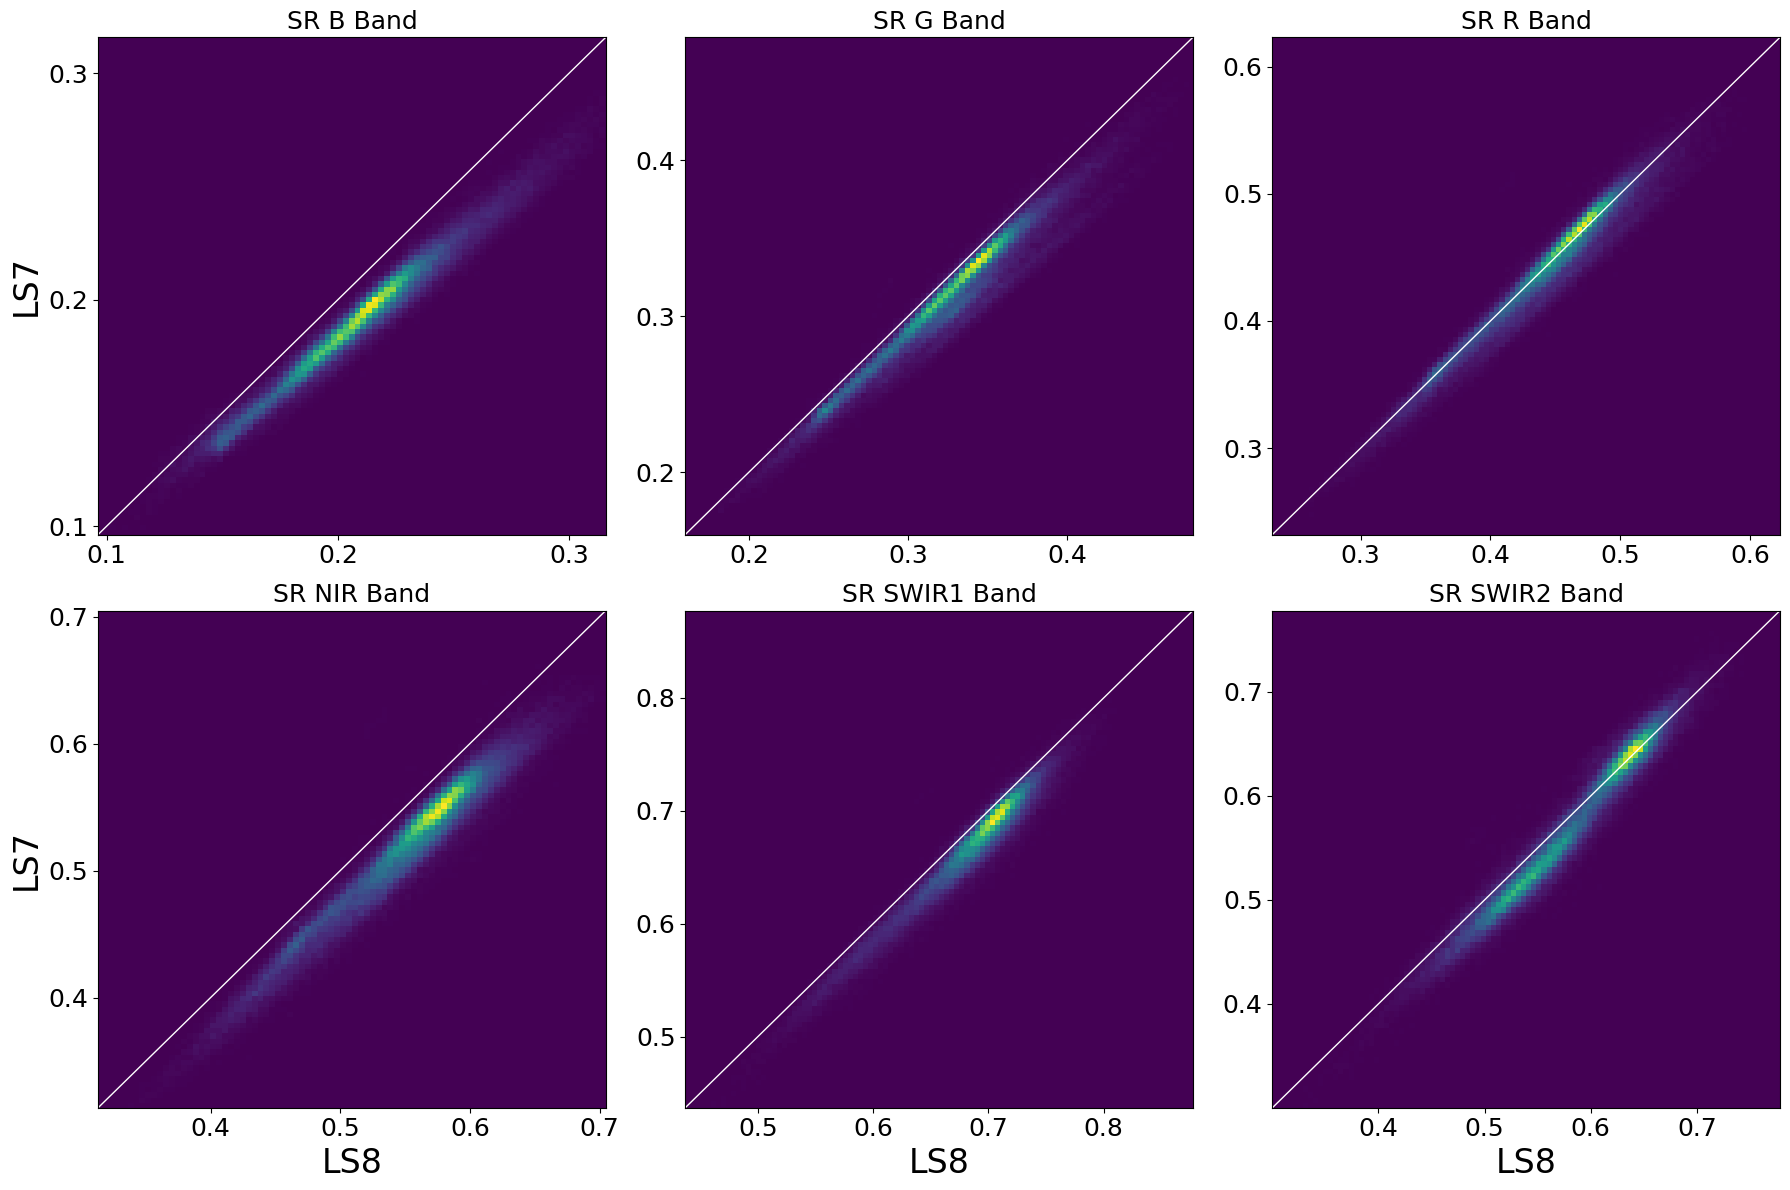


OLS
B: LS7 = 0.8526LS8 + 0.0121
G: LS7 = 0.9181LS8 + 0.0118
R: LS7 = 0.9841LS8 + 0.0033
NIR: LS7 = 0.9566LS8 + -0.0091
SWIR1: LS7 = 0.9943LS8 + -0.014
SWIR2: LS7 = 1.1052LS8 + -0.0708

TheilSen
B: LS7 = 0.8658LS8 + 0.0095
G: LS7 = 0.9438LS8 + 0.0058
R: LS7 = 1.0052LS8 + -0.0038
NIR: LS7 = 0.9643LS8 + -0.0121
SWIR1: LS7 = 1.0135LS8 + -0.0256
SWIR2: LS7 = 1.1218LS8 + -0.0801

RMA
B: LS7 = 0.9799LS8 + -0.0146
G: LS7 = 0.9694LS8 + -0.0049
R: LS7 = 0.9715LS8 + 0.0089
NIR: LS7 = 0.9679LS8 + -0.0154
SWIR1: LS7 = 0.9607LS8 + 0.009
SWIR2: LS7 = 0.9744LS8 + 0.005


In [22]:
#4. Running DEEP LEOHS multiple times on AOI
Repeats=2 #number of times you want to run DEEP LEOHS
WRS_gdf,full_AOI=create_WRS_gdf(Aoi_shp_path, wrs_shp_path) #this has all combinations of L+R overlaps for every WRS Tile
full_AOI,strips=split_aoi_into_strips(full_AOI)
overlap_df,frequency_gdf=create_overlap_df(harmonization_order,full_AOI,strips)
Save_folder_path_original=Save_folder_path
Save_data_original = Save_data
for value in range(Repeats):
    Save_folder_path=f'{Save_folder_path_original}{value+1}'
    create_save_path()
    Sample_points_gdf,overlap_points_gdf=run_workflow(full_AOI,sample_points_n,frequency_gdf)
    gdfs=split_gdf_into_equal_parts(overlap_points_gdf, num_parts=10)
    all_big_gdf=gpd.GeoDataFrame()
    for overlap_points_gdf in gdfs:
        overlap_imgs_df=create_img_df(overlap_df) #creates a df up to Max_img_samples per unique overlap
        unique_row_path_list=get_unique_combinations_as_dicts(overlap_df) #makes a list of all the unique overlaps
        Save_data= False
        big_gdf=create_big_gdf(unique_row_path_list) #samples points in images found in overlap locations, filters out invalid pixels
        all_big_gdf = pd.concat([all_big_gdf, big_gdf], ignore_index=True)
    Save_data = Save_data_original
    if Save_data==True:
        dtype=toa_or_sr(LS8,LS7)
        col_names=get_var_names_from_list(harmonization_order)
        all_big_gdf.to_file(f'{Save_folder_path}\\{dtype}_Landsatsamples.shp', driver='ESRI Shapefile')
        all_big_gdf.to_csv(f'{Save_folder_path}\\{dtype}_Landsatsamples.csv')
    harmonization_order=[LS7,LS8]
    process_all_regressions(all_big_gdf, Regression_types) #regresses, then plots data and prints equations
    harmonization_order=[LS8,LS7]
    process_all_regressions(all_big_gdf, Regression_types) #regresses, then plots data and prints equations